In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline
import plotly.plotly as py
import plotly
import os
import IPython.display 

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

# Thinkful Capstone: Exploring Hospital Fall Rates in 500 U.S. Cities.

My Capstone project is to create an algorithm that can better predict and explain hospital patient fall rates. 

### Why Explain and Predict Hospital Falls?

   Hospitals have a major incentive to decrease falls due to the likely increase in patient care costs, length of stay, and liability. Furthermore, the Centers for Medicare and Medicaid Services (CMS) no longer pays for health care costs associated with falls during hospitalization, after deeming them events that should never occur during hospitalization [1].
   
   Helping hospitals focus their time and money on where they need to use to their resources is the primary goal of this project. A consulting healthcare company could market this model towards helping lower hospital acquired condition rates. Additionally, a public health agency might want this model to categorize and monitor how hospitals are performing.

### Gathering and Scraping Data

   I compiled a list of hospitals with patient fall rates from two separate sources: Hospital-Data [2] and the Centers for Medicare & Medicaid Services [3]. Once I had these two datafiles, I then gathered data about these hospitals, cities, and states to use as features. One feature is indicating whether a hospital is an adult and/or pediatric trauma center [4]. Additional features include the rates of obesity, binge drinking, and stroke for cities in the US [5]. The last feature is the state level healthcare employee injury rates [6]. These are some of the features that I believe will help with my model’s explanation and prediction.
   
   The code for my data scraping that I did for this project can be found here: https://github.com/BDSpecial/Thinkful-Capstone-Projects/blob/master/Capstone-Data.ipynb

# Cleaning All Data Sources

## Scraped Fall Data

This is the fall data that I scraped from Hospital-data.com. Here you will see me take the data that I scraped and clean it into a dataset where each hospital has a separate column for its city, state, individual fall rate, and state fall rate. 

In [2]:
fall_data = pd.read_json('hospital_data.json', orient='records')
print(fall_data.shape)
print(fall_data.head())

(2261, 3)
                                           hospital hospital_falls state_falls
0                BECKLEY ARH HOSPITAL - BECKLEY, WV         2.096%      0.833%
1  CAMPBELL COUNTY MEMORIAL HOSPITAL - GILLETTE, WY         0.727%      1.114%
2      ALASKA NATIVE MEDICAL CENTER - ANCHORAGE, AK         1.312%      1.414%
3  ADVENTIST MEDICAL CENTER - REEDLEY - REEDLEY, CA         1.522%      0.625%
4              BRIDGEPORT HOSPITAL - BRIDGEPORT, CT         0.622%      0.552%


In [3]:
fall_list = []
state_fall = []
for each in fall_data.hospital_falls:
    fall_list.append(each.split("%")[0])
for each in fall_data.state_falls:
    state_fall.append(each.split("%")[0])

In [4]:
fall_data['hospital_falls'] = fall_list
fall_data['state_falls'] = state_fall

In [5]:
states_data = []
for each in fall_data.hospital:
    states_data.append(each.split(",")[-1])

In [6]:
city_data = []
cities = []
hospitals = []
for each in fall_data.hospital:
    hospitals.append(each.split("-")[:-1])
    city_data.append(each.split("-")[-1])
for each in city_data:
    cities.append(each.split(",")[0])

In [7]:
fall_data['state'] = states_data
fall_data['city'] = cities
fall_data['hospital'] = hospitals

In [8]:
hospital_list = []
for each in fall_data.hospital:
    hospital_list.append("".join(each))

In [9]:
each_hospital = []
for each in hospital_list:
    item = each.split("  ")
    each_hospital.append(" ".join(item))

In [10]:
fall_data['hospital'] = each_hospital

In [11]:
fall_data = fall_data.sort_values(by=['state','city'])

In [12]:
fall_data['hospital'] = fall_data.hospital.str.title()
fall_data['city'] = fall_data.city.str.title()
fall_data['hospital'] = fall_data.hospital.str.strip()
fall_data['city'] = fall_data.city.str.strip()
fall_data['state'] = fall_data.state.str.strip()

In [13]:
fall_data.index = range(len(fall_data.index))

In [14]:
fall_data.dtypes

hospital          object
hospital_falls    object
state_falls       object
state             object
city              object
dtype: object

In [15]:
fall_data.hospital_falls = fall_data.hospital_falls.astype(float)
fall_data.state_falls = fall_data.state_falls.astype(float)

In [16]:
print(fall_data.shape)
fall_data.head()

(2261, 5)


,hospital,hospital_falls,state_falls,state,city
0,Alaska Native Medical Center,1.312,1.414,AK,Anchorage
1,Yukon Kuskokwim Delta Reg Hospital,1.742,1.414,AK,Bethel
2,Fairbanks Memorial Hospital,0.790,1.414,AK,Fairbanks
3,Mt Edgecumbe Hospital,1.812,1.414,AK,Sitka
4,Shelby Baptist Medical Center,0.141,0.715,AL,Alabaster


Now that I have a clean dataset, I am going to explore the distribution of this dataset and see if I can form meaningful clusters. 

In [17]:
# Here I am saving this dataset to a csv file. 
fall_data.to_csv('fall_data.csv', index=False)

In [18]:
fall_data.describe()

,hospital_falls,state_falls
count,2261.000000,2261.000000
mean,0.713582,0.715199
std,0.679179,0.166475
min,0.062000,0.479000
25%,0.367000,0.625000
50%,0.563000,0.681000
75%,0.840000,0.749000
max,11.628000,1.414000


During this first clustering, my dependent feature is a binary version of hospital_falls and the other features that I am going to use are state_falls and individual states. I decided to separate the binary dependent outcome on hospital fall rates that are greater than 0.7 since the 50th percentile is at 0.56 or below. I chose to separate my data into three clusters for a high, low, and unknown group of hospitals. 

In [19]:
# Define the features and the outcome.
X = fall_data.drop(['hospital', 'hospital_falls', 'city'], axis=1)
y = fall_data.hospital_falls

# In order to have the states as a feature I need use get_dummies
X = pd.get_dummies(X)

# Binarize y so that 1 means a high fall rate and 0 is a low fall rate. 
y = np.where(y >= 0.7, 1, 0)

In [20]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X)

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Comparing k-means clusters against the data:
col_0    0    1
row_0          
0      748  496
1      105   89
2      597  226


In [21]:
fall_data['cluster'] = y_pred 

In [22]:
fall_data.head()

,hospital,hospital_falls,state_falls,state,city,cluster
0,Alaska Native Medical Center,1.312,1.414,AK,Anchorage,0
1,Yukon Kuskokwim Delta Reg Hospital,1.742,1.414,AK,Bethel,0
2,Fairbanks Memorial Hospital,0.790,1.414,AK,Fairbanks,0
3,Mt Edgecumbe Hospital,1.812,1.414,AK,Sitka,0
4,Shelby Baptist Medical Center,0.141,0.715,AL,Alabaster,0


In [23]:
fall_data.groupby('cluster').hospital_falls.mean()

cluster
0    0.771009
1    0.892716
2    0.584554
Name: hospital_falls, dtype: float64

From this clustering, it appears that cluster 1 has on average a higher fall rate at 0.89 and cluster 2 the lowest of the fall rates at 0.58. 

In [24]:
fall_data = fall_data.drop(['cluster'], axis=1)

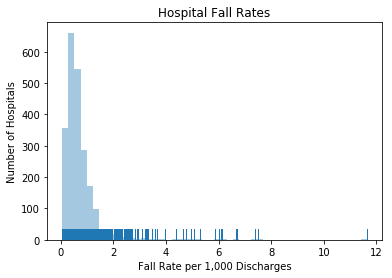

In [25]:
fig = sns.distplot(fall_data.hospital_falls, kde=False, rug=True)
plt.xlabel("Fall Rate per 1,000 Discharges")
plt.ylabel("Number of Hospitals")
plt.title('Hospital Fall Rates')
plt.show(fig)

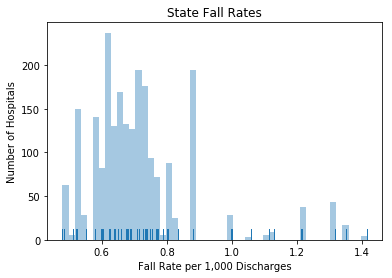

In [26]:
fig = sns.distplot(fall_data.state_falls, kde=False, rug=True)
plt.xlabel("Fall Rate per 1,000 Discharges")
plt.ylabel("Number of Hospitals")
plt.title('State Fall Rates')
plt.show(fig)

Lastly, I am going to create a choropleth map of the United States for the state fall rates. 

In [27]:
scraped_state_fall_dictionary = {}
for each in fall_data.state.unique():
    for i in range(len(fall_data)):
        if fall_data.state[i] == each:
            scraped_state_fall_dictionary[each] = fall_data.state_falls[i]
            break

In [28]:
scraped_state_fall = pd.DataFrame()
scraped_state_fall['state'] = scraped_state_fall_dictionary.keys()
scraped_state_fall['state_fall_rate'] = scraped_state_fall_dictionary.values()

In [29]:
scraped_state_fall.head()

,state,state_fall_rate
0,AK,1.414
1,AL,0.715
2,AR,0.772
3,AZ,0.801
4,CA,0.625


In [30]:
# Here I am saving this dataset to a csv file. 
scraped_state_fall.to_csv('scraped_state_fall.csv', index=False)

In [31]:
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *

init_notebook_mode(connected=True) 

scl = [[0.0, 'rgb(255, 255, 204)'],[0.25, 'rgb(161, 218, 180)'],[0.5, 'rgb(65, 182, 196)'],\
            [0.6, 'rgb(44, 127, 184)'],[0.7, 'rgb(8, 104, 172)'],[1.0, 'rgb(37, 52, 148)']]


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = scraped_state_fall.state,
        z = scraped_state_fall.state_fall_rate,
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(55,55,155)',
                width = 1
            ) ),
        colorbar = dict(
            title = "Rate per 1,000 discharges")
        ) ]

layout = dict(
        title = 'State Average Hospital Falls',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot(fig)

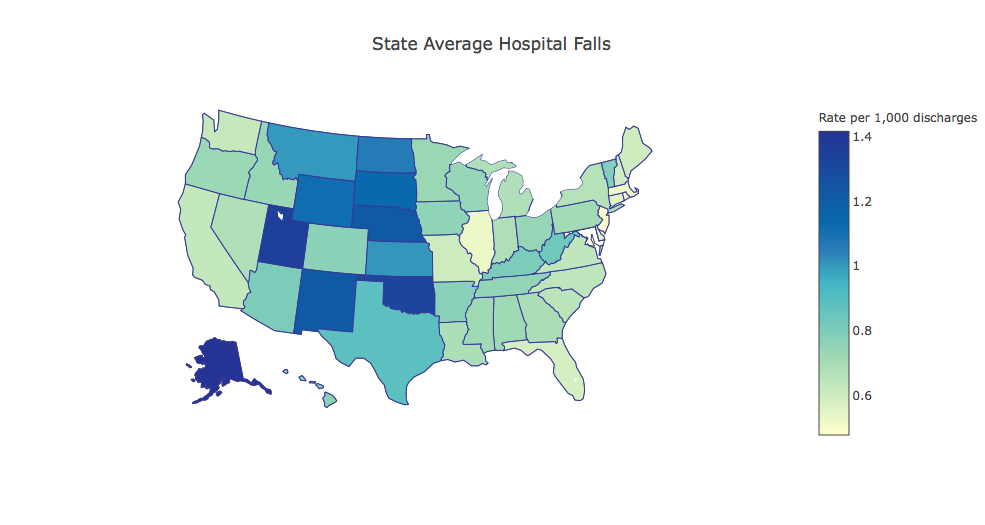

In [32]:
scraped_fall_image = IPython.display.Image(filename='scraped_falls.png')
scraped_fall_image

I can easily see that the large majority of hospital falls are less than 2 per 1,000 discharges with a mean of 0.71 and a max of 11.6. Additionally, this fall dataset has the majority of state fall rates around 0.7 per 1,000 discharges. When I graph the state average fall rates onto a map of the United States, I can see that the higher fall rates there appear to be in the mid-western states. 

## CMS Fall Data

This is a separate fall rate dataset that is from the Centers for Medicare & Medicaid Services. Here I will separate out the fall data from other Hospital Acquired Conditions in the CMS dataset. Then I will merge this dataset with the CMS hospital data which allows me to identify the name, state, and city of each hospital. Once I have the fall rate and details for each hospital, I will calculate the state average fall rate for this dataset. 

In [33]:
second_falls = pd.read_csv('Selected_Hospital_Level_HAC_Rates.csv')
print(second_falls.shape)
print(second_falls.head())

(39240, 5)
   Hospital ID Number           Measure Name  Rate per 1,000 discharges  \
0               10001         FOREIGN OBJECT                      0.062   
1               10001           AIR EMBOLISM                      0.000   
2               10001  BLOOD INCOMPATIBILITY                      0.000   
3               10001         PRESSURE ULCER                      0.062   
4               10001       FALLS AND TRAUMA                      0.812   

  START_QUARTER END_QUARTER  
0        3Q2010      2Q2012  
1        3Q2010      2Q2012  
2        3Q2010      2Q2012  
3        3Q2010      2Q2012  
4        3Q2010      2Q2012  


In [34]:
CMS_falls = second_falls[second_falls['Measure Name'] == 'FALLS AND TRAUMA']

In [35]:
#Before I go any further I want to check in there are any null values in my dataset
print(CMS_falls.isnull().sum())

Hospital ID Number              0
Measure Name                    0
Rate per 1,000 discharges    1579
START_QUARTER                   0
END_QUARTER                     0
dtype: int64


In [36]:
CMS_falls = CMS_falls.dropna()
CMS_falls.index = range(len(CMS_falls.index))

In [37]:
CMS_falls = CMS_falls.drop(['START_QUARTER', 'END_QUARTER'], axis=1)
CMS_falls.columns = ['hospital_ID', 'measure_name', 'hospital_fall_rate']
CMS_falls['state_average'] = None

In [38]:
print(CMS_falls.shape)
CMS_falls.head()

(3326, 4)


,hospital_ID,measure_name,hospital_fall_rate,state_average
0,10001,FALLS AND TRAUMA,0.812,None
1,10005,FALLS AND TRAUMA,0.445,None
2,10006,FALLS AND TRAUMA,0.182,None
3,10007,FALLS AND TRAUMA,1.042,None
4,10008,FALLS AND TRAUMA,0.000,None


In [39]:
hospital_info = pd.read_csv('Hospital_General_Information.csv')
print(hospital_info.shape)
print(hospital_info.iloc[:, 0:3].head())

(4806, 29)
   Provider ID                   Hospital Name                     Address
0        10005   MARSHALL MEDICAL CENTER SOUTH  2505 U S HIGHWAY 431 NORTH
1        10012  DEKALB REGIONAL MEDICAL CENTER        200 MED CENTER DRIVE
2        10032                WEDOWEE HOSPITAL       209 NORTH MAIN STREET
3        10095            HALE COUNTY HOSPITAL            508 GREEN STREET
4        10131        CRESTWOOD MEDICAL CENTER          ONE HOSPITAL DR SE


In [40]:
hospital_info = hospital_info.sort_values(by=['Provider ID'])
hospital_info.index = range(len(hospital_info.index))

In [41]:
hospital_info.columns

Index(['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'Hospital Type', 'Hospital Ownership',
       'Emergency Services', 'Meets criteria for meaningful use of EHRs',
       'Hospital overall rating', 'Hospital overall rating footnote',
       'Mortality national comparison',
       'Mortality national comparison footnote',
       'Safety of care national comparison',
       'Safety of care national comparison footnote',
       'Readmission national comparison',
       'Readmission national comparison footnote',
       'Patient experience national comparison',
       'Patient experience national comparison footnote',
       'Effectiveness of care national comparison',
       'Effectiveness of care national comparison footnote',
       'Timeliness of care national comparison',
       'Timeliness of care national comparison footnote',
       'Efficient use of medical imaging national comparison',
       'Efficient use of medi

In [42]:
hospital_info = hospital_info.loc[:, ['Provider ID', 'Hospital Name', 'City', 'State']]

In [43]:
hospital_info.columns = ['ID', 'hospital', 'city', 'state']

In [44]:
hospital_info['hospital'] = hospital_info.hospital.str.title()
hospital_info['city'] = hospital_info.city.str.title()
hospital_info['hospital'] = hospital_info.hospital.str.strip()
hospital_info['city'] = hospital_info.city.str.strip()
hospital_info['state'] = hospital_info.state.str.strip()

In [45]:
hospital_info.head()

,ID,hospital,city,state
0,10001,Southeast Alabama Medical Center,Dothan,AL
1,10005,Marshall Medical Center South,Boaz,AL
2,10006,Eliza Coffee Memorial Hospital,Florence,AL
3,10007,Mizell Memorial Hospital,Opp,AL
4,10008,Crenshaw Community Hospital,Luverne,AL


In [46]:
CMS_Data = pd.merge(CMS_falls, hospital_info, left_on="hospital_ID", right_on="ID")

In [47]:
CMS_Data = CMS_Data.drop(['hospital_ID', 'ID', 'measure_name'], axis=1)

In [48]:
print(CMS_Data.shape)
CMS_Data.head()

(3140, 5)


,hospital_fall_rate,state_average,hospital,city,state
0,0.812,None,Southeast Alabama Medical Center,Dothan,AL
1,0.445,None,Marshall Medical Center South,Boaz,AL
2,0.182,None,Eliza Coffee Memorial Hospital,Florence,AL
3,1.042,None,Mizell Memorial Hospital,Opp,AL
4,0.000,None,Crenshaw Community Hospital,Luverne,AL


Here I am calculating the average state fall rate by making a list of all the states in the dataset. If a hospital is located in a state then I add its fall rate to a total and increase the number of hospitals in that state by one. I calculate the average by dividing the sum total by the number of hospitals in that state. To finish, I add the state and it's calculated state average fall rate to a dictionary. 

Then I will create a choropleth map of the United States for the CMS state fall rates. 

In [49]:
CMS_state_fall_dictionary = {}
for each in CMS_Data.state.unique():
    total = 0
    number = 0
    for i in range(len(CMS_Data)):
        if CMS_Data.state[i] == each:
            total += CMS_Data.hospital_fall_rate[i]
            number += 1
            CMS_state_fall_dictionary[each] = round(total/number,3)

In [50]:
CMS_state_fall = pd.DataFrame()
CMS_state_fall['state'] = CMS_state_fall_dictionary.keys()
CMS_state_fall['state_fall_rate'] = CMS_state_fall_dictionary.values()

In [51]:
CMS_state_fall.head()

,state,state_fall_rate
0,AL,0.437
1,AK,0.485
2,AZ,0.562
3,AR,0.665
4,CA,0.392


In [52]:
# Here I am saving this dataset to a csv file. 
CMS_state_fall.to_csv('CMS_state_fall.csv', index=False)

In [53]:
scl = [[0.0, 'rgb(255, 255, 204)'],[0.25, 'rgb(161, 218, 180)'],[0.5, 'rgb(65, 182, 196)'],\
            [0.6, 'rgb(44, 127, 184)'],[0.7, 'rgb(8, 104, 172)'],[1.0, 'rgb(37, 52, 148)']]


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = CMS_state_fall.state.unique(),
        z = CMS_state_fall.state_fall_rate.astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(55,55,155)',
                width = 1
            ) ),
        colorbar = dict(
            title = "Rate per 1,000 discharges")
        ) ]

layout = dict(
        title = 'CMS State Average Fall Rates',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot(fig)

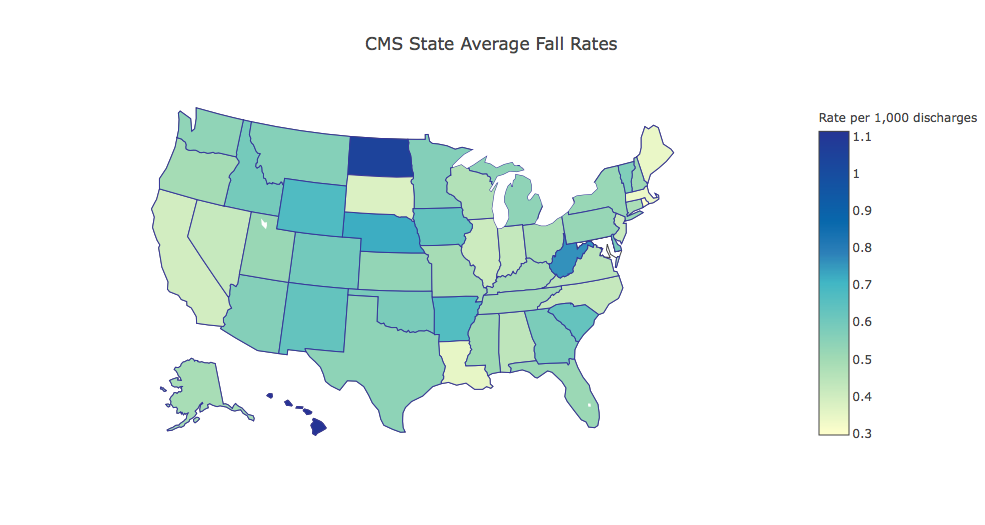

In [54]:
CMS_fall_image = IPython.display.Image(filename='CMS_falls.png')
CMS_fall_image

Now I am inserting these newly calculated state_average fall rates into the appropriate rows. 

In [55]:
for i in range(len(CMS_Data)):
    for each in CMS_state_fall_dictionary:
        if CMS_Data.state[i] == each:
            CMS_Data.loc[i, 'state_average'] = CMS_state_fall_dictionary[each]

In [56]:
CMS_Data.dtypes

hospital_fall_rate    float64
state_average          object
hospital               object
city                   object
state                  object
dtype: object

In [57]:
CMS_Data.state_average = CMS_Data.state_average.astype(float)

In [58]:
CMS_Data.head()

,hospital_fall_rate,state_average,hospital,city,state
0,0.812,0.437,Southeast Alabama Medical Center,Dothan,AL
1,0.445,0.437,Marshall Medical Center South,Boaz,AL
2,0.182,0.437,Eliza Coffee Memorial Hospital,Florence,AL
3,1.042,0.437,Mizell Memorial Hospital,Opp,AL
4,0.000,0.437,Crenshaw Community Hospital,Luverne,AL


In [59]:
# Here I am saving this dataset to a csv file. 
CMS_Data.to_csv('CMS_Data.csv', index=False)

In [60]:
CMS_Data.describe()

,hospital_fall_rate,state_average
count,3140.000000,3140.000000
mean,0.497063,0.497127
std,0.610596,0.093727
min,0.000000,0.295000
25%,0.000000,0.423000
50%,0.397000,0.513000
75%,0.660000,0.540000
max,7.874000,1.113000


During this clustering, my dependent feature will again be a binary version of the hospital_fall_rate and the other features that I am going to use are state_average and individual states. I decided to separate the binary dependent outcome on hospital fall rates that are greater than 0.5 since 50% of the data is at 0.39 or below. I again chose to separate my data into three clusters for a high, low, and unknown group of hospitals. 

In [61]:
# Define the features and the outcome.
X = CMS_Data.drop(['hospital', 'hospital_fall_rate', 'city'], axis=1)
y = CMS_Data.hospital_fall_rate

# In order to have the states as a feature I need use get_dummies
X = pd.get_dummies(X)

# Binarize y so that 1 means a high fall rate and 0 is a low fall rate. 
y = np.where(y >= 0.5, 1, 0)

In [62]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X)

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Comparing k-means clusters against the data:
col_0     0    1
row_0           
0       366  205
1      1310  971
2       217   71


In [63]:
CMS_Data['cluster'] = y_pred 

In [64]:
CMS_Data.head()

,hospital_fall_rate,state_average,hospital,city,state,cluster
0,0.812,0.437,Southeast Alabama Medical Center,Dothan,AL,0
1,0.445,0.437,Marshall Medical Center South,Boaz,AL,0
2,0.182,0.437,Eliza Coffee Memorial Hospital,Florence,AL,0
3,1.042,0.437,Mizell Memorial Hospital,Opp,AL,0
4,0.000,0.437,Crenshaw Community Hospital,Luverne,AL,0


In [65]:
CMS_Data.groupby('cluster').hospital_fall_rate.mean()

cluster
0    0.427375
1    0.527829
2    0.391563
Name: hospital_fall_rate, dtype: float64

From this clustering, it appears that the hospital fall rate is evenly distributed between the clusters. The fall rate between the clusters ranges from 0.39 to 0.52.  

In [66]:
CMS_Data = CMS_Data.drop(['cluster'], axis=1)

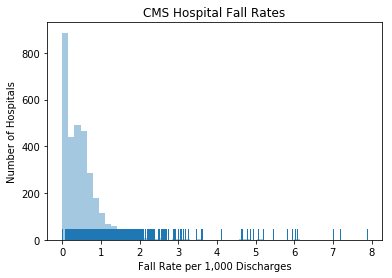

In [67]:
fig = sns.distplot(CMS_Data.hospital_fall_rate, kde=False, rug=True)
plt.xlabel("Fall Rate per 1,000 Discharges")
plt.ylabel("Number of Hospitals")
plt.title('CMS Hospital Fall Rates')
plt.show(fig)

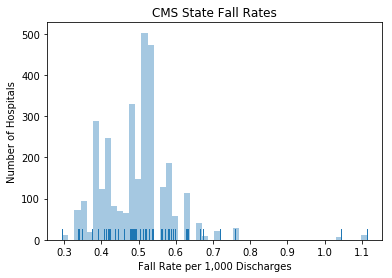

In [68]:
fig = sns.distplot(CMS_Data.state_average, kde=False, rug=True)
plt.xlabel("Fall Rate per 1,000 Discharges")
plt.ylabel("Number of Hospitals")
plt.title('CMS State Fall Rates')
plt.show(fig)

After exploring its layout, you can see that these hospital falls rates have a smaller distribution with the max of 7.8. The large majority of hospital fall rates are less than 1 per 1,000 discharges with a mean of 0.49. The state fall rates are also lower at 0.49 per 1,000 discharges. When I look at the state fall rate layout on the map of the United States, it appears to be more evenly distributed across the country.

## Combining Both Fall Datasets

Here I am going to merge the two fall datasets. I will initially merge the datasets on hospitals that have the same name. If two hospitals have the same name but are located in different places, then I will of course remove these from the dataset. 

Next, I am going to isolate the hospitals that were missed in this merge. Many of the hospitals in both datasets have slightly different names. To address this problem I am going to loop through the missed hospitals from both dataset and select hospitals that are in the same state and city. If these hospitals from both datasets have similar names then I feel confident to say that they are the same hospital and I will merge them into one dataset. 

Lastly, I will join together the initially merged dataset and looped over dataset. 

In [69]:
both_fall = pd.merge(fall_data, CMS_Data, on='hospital')

In [70]:
for i in range(len(both_fall)):
    if both_fall.state_x[i] != both_fall.state_y[i]:
        both_fall.drop(i, inplace=True)

In [71]:
both_fall = both_fall.drop(['state_y', 'city_y'], axis=1)
both_fall.rename(columns={'city_x':'city', 'state_x': 'state'}, inplace=True)
both_fall.index = range(len(both_fall.index))

In [72]:
print(both_fall.shape)
both_fall.head()

(1576, 7)


,hospital,hospital_falls,state_falls,state,city,hospital_fall_rate,state_average
0,Alaska Native Medical Center,1.312,1.414,AK,Anchorage,1.544,0.485
1,Yukon Kuskokwim Delta Reg Hospital,1.742,1.414,AK,Bethel,0.000,0.485
2,Fairbanks Memorial Hospital,0.790,1.414,AK,Fairbanks,0.737,0.485
3,Shelby Baptist Medical Center,0.141,0.715,AL,Alabaster,0.412,0.437
4,Russell Hospital,0.621,0.715,AL,Alexander City,0.310,0.437


In [73]:
unmerged_fall = pd.merge(fall_data, CMS_Data, on='hospital', how='outer')

In [74]:
print(unmerged_fall.shape)
unmerged_fall.head()

(4116, 9)


,hospital,hospital_falls,state_falls,state_x,city_x,hospital_fall_rate,state_average,city_y,state_y
0,Alaska Native Medical Center,1.312,1.414,AK,Anchorage,1.544,0.485,Anchorage,AK
1,Yukon Kuskokwim Delta Reg Hospital,1.742,1.414,AK,Bethel,0.000,0.485,Bethel,AK
2,Fairbanks Memorial Hospital,0.790,1.414,AK,Fairbanks,0.737,0.485,Fairbanks,AK
3,Mt Edgecumbe Hospital,1.812,1.414,AK,Sitka,NaN,NaN,NaN,NaN
4,Shelby Baptist Medical Center,0.141,0.715,AL,Alabaster,0.412,0.437,Alabaster,AL


In [75]:
missed_scraped = unmerged_fall[unmerged_fall['hospital_falls'].isnull()]
missed_CMS = unmerged_fall[unmerged_fall['hospital_fall_rate'].isnull()]
missed_scraped.index = range(len(missed_scraped.index))
missed_CMS.index = range(len(missed_CMS.index))

In [76]:
words_list = ['Hospital', 'Medical', 'Center', 'Health', 'System', 'Hospitals', 'Foundation', 'Kaiser']
for i in range(len(missed_scraped)):
    for j in range(len(missed_CMS)):
        if (missed_scraped.state_y[i] == missed_CMS.state_x[j]) and (missed_scraped.city_y[i] == missed_CMS.city_x[j]):
            list_one = missed_scraped.hospital[i].split()
            list_two = missed_CMS.hospital[j].split()
            together = list(set(list_one) & set(list_two) - set(words_list))
            if len(together) >= 1:
                missed_scraped.loc[i, 'hospital_falls':'city_x'] = missed_CMS.loc[j, 'hospital_falls':'city_x']
                break

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [77]:
missed_scraped = missed_scraped[missed_scraped.hospital_falls.notnull()]
missed_scraped = missed_scraped.drop(['state_y', 'city_y'], axis=1)
missed_scraped.rename(columns={'city_x':'city', 'state_x': 'state'}, inplace=True)
missed_scraped.index = range(len(missed_scraped.index))

In [78]:
print(missed_scraped.shape)
missed_scraped.head()

(493, 7)


,hospital,hospital_falls,state_falls,state,city,hospital_fall_rate,state_average
0,Jackson Hospital & Clinic Inc,0.663,0.715,AL,Montgomery,0.367,0.437
1,East Alabama Medical Center,0.169,0.715,AL,Opelika,0.251,0.437
2,Decatur Morgan Hospital-Decatur Campus,0.443,0.715,AL,Decatur,0.549,0.437
3,University Of South Alabama Medical Center,0.397,0.715,AL,Mobile,0.000,0.437
4,Princeton Baptist Medical Center,0.238,0.715,AL,Birmingham,0.810,0.437


In [79]:
df_list = [both_fall, missed_scraped]

In [80]:
complete_data = pd.concat(df_list)
complete_data = complete_data.sort_values(by=['state','city'])
complete_data.index = range(len(complete_data.index))

In [81]:
print(fall_data.shape)
print(CMS_Data.shape)
print(complete_data.shape)

(2261, 5)
(3140, 5)
(2069, 7)


In [82]:
complete_data.head()

,hospital,hospital_falls,state_falls,state,city,hospital_fall_rate,state_average
0,Alaska Native Medical Center,1.312,1.414,AK,Anchorage,1.544,0.485
1,Yukon Kuskokwim Delta Reg Hospital,1.742,1.414,AK,Bethel,0.000,0.485
2,Fairbanks Memorial Hospital,0.790,1.414,AK,Fairbanks,0.737,0.485
3,Shelby Baptist Medical Center,0.141,0.715,AL,Alabaster,0.412,0.437
4,Russell Hospital,0.621,0.715,AL,Alexander City,0.310,0.437


# Calculating Fall Meta-Analysis

Now, here is where I performed the meta analysis. I first created two empty columns, hospital_average and combined_state_average where I will put my calculated numbers. I loop through the entire joined_fall dataset and for each individual hospital, I average two numbers. The hospital_average is the hospital's fall rates from the hospital-data.com and the CMS sources that are added together and then divided by two and rounded to the third decimal point. Similarly, the combined_state_average is each hospital's state fall rate from the hospital-data.com and the one that I calculated from the CMS data above. I will again take these two numbers and average them out by adding them together and dividing by two and rounding it to the third decimal point.

Once I have calculated the meta-analysis for hospital and state fall rates, I will perform the same clustering and visualization of the hospital and state fall rates that I performed on the scraped and CMS fall datasets earlier. 

In [83]:
complete_data['meta_hospital_fall'] = None
complete_data['meta_state_fall'] = None
for i in range(len(complete_data)):
    complete_data.loc[i, 'meta_hospital_fall'] = round(complete_data.hospital_falls[i] + complete_data.hospital_fall_rate[i],3)/2
    complete_data.loc[i, 'meta_state_fall'] = round(complete_data.state_falls[i] + complete_data.state_average[i],3)/2

In [84]:
complete_data.head()

,hospital,hospital_falls,state_falls,state,city,hospital_fall_rate,state_average,meta_hospital_fall,meta_state_fall
0,Alaska Native Medical Center,1.312,1.414,AK,Anchorage,1.544,0.485,1.428,0.9495
1,Yukon Kuskokwim Delta Reg Hospital,1.742,1.414,AK,Bethel,0.000,0.485,0.871,0.9495
2,Fairbanks Memorial Hospital,0.790,1.414,AK,Fairbanks,0.737,0.485,0.7635,0.9495
3,Shelby Baptist Medical Center,0.141,0.715,AL,Alabaster,0.412,0.437,0.2765,0.576
4,Russell Hospital,0.621,0.715,AL,Alexander City,0.310,0.437,0.4655,0.576


In [85]:
complete_data = complete_data.loc[:, ['hospital', 'state', 'city', 'meta_hospital_fall', 'meta_state_fall']]

In [86]:
complete_data.dtypes

hospital              object
state                 object
city                  object
meta_hospital_fall    object
meta_state_fall       object
dtype: object

In [87]:
complete_data.meta_hospital_fall = complete_data.meta_hospital_fall.astype(float)
complete_data.meta_state_fall = complete_data.meta_state_fall.astype(float)

In [88]:
complete_data.describe()

,meta_hospital_fall,meta_state_fall
count,2069.000000,2069.000000
mean,0.639236,0.606471
std,0.572462,0.112749
min,0.038500,0.387000
25%,0.345500,0.531000
50%,0.519000,0.589500
75%,0.746000,0.646500
max,7.283000,1.050500


During this clustering, my dependent feature will again be a binary version of meta_hospital_fall and the other features that I am going to use are meta_state_fall and individual states. I decided to separate the binary dependent outcome on hospital fall rates that are greater than 0.6 since 50% of the data is at 0.51 or below. I again chose to separate my data into three clusters for a high, low, and unknown group of hospitals. 

In [89]:
# Define the features and the outcome.
X = complete_data.drop(['hospital', 'meta_hospital_fall', 'city'], axis=1)
y = complete_data.meta_hospital_fall

# In order to have the states as a feature I need use get_dummies
X = pd.get_dummies(X)

# Binarize y so that 1 means a high fall rate and 0 is a low fall rate. 
y = np.where(y >= 0.6, 1, 0)

In [90]:
#Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X)

#Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Comparing k-means clusters against the data:
col_0    0    1
row_0          
0      516  242
1       98   91
2      628  494


In [91]:
complete_data['cluster'] = y_pred 
complete_data.head()

,hospital,state,city,meta_hospital_fall,meta_state_fall,cluster
0,Alaska Native Medical Center,AK,Anchorage,1.4280,0.9495,2
1,Yukon Kuskokwim Delta Reg Hospital,AK,Bethel,0.8710,0.9495,2
2,Fairbanks Memorial Hospital,AK,Fairbanks,0.7635,0.9495,2
3,Shelby Baptist Medical Center,AL,Alabaster,0.2765,0.5760,2
4,Russell Hospital,AL,Alexander City,0.4655,0.5760,2


In [92]:
complete_data.groupby('cluster').meta_hospital_fall.mean()

cluster
0    0.536786
1    0.782341
2    0.684343
Name: meta_hospital_fall, dtype: float64

From this clustering, it appears that cluster 1 has on average a higher fall rate at 0.78 and cluster 0 the lowest of the fall rates at 0.53.

In [93]:
complete_data = complete_data.drop(['cluster'], axis=1)

In [94]:
#Here I am saving this dataset to a csv file. 
complete_data.to_csv('complete_data.csv', index=False)

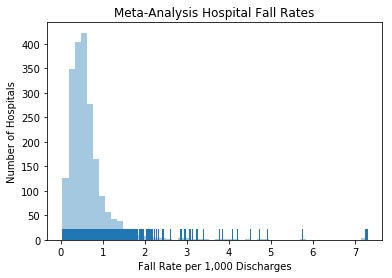

In [95]:
fig = sns.distplot(complete_data.meta_hospital_fall, kde=False, rug=True)
plt.xlabel("Fall Rate per 1,000 Discharges")
plt.ylabel("Number of Hospitals")
plt.title('Meta-Analysis Hospital Fall Rates')
plt.show(fig)

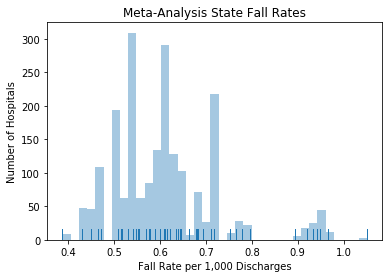

In [96]:
fig = sns.distplot(complete_data.meta_state_fall, kde=False, rug=True)
plt.xlabel("Fall Rate per 1,000 Discharges")
plt.ylabel("Number of Hospitals")
plt.title('Meta-Analysis State Fall Rates')
plt.show(fig)

In [97]:
meta_state_fall_dictionary = {}
for each in complete_data.state.unique():
    for i in range(len(complete_data)):
        if complete_data.state[i] == each:
            meta_state_fall_dictionary[each] = complete_data.meta_state_fall[i]
            break

In [98]:
meta_state_fall = pd.DataFrame()
meta_state_fall['state'] = meta_state_fall_dictionary.keys()
meta_state_fall['state_fall_rate'] = meta_state_fall_dictionary.values()

In [99]:
meta_state_fall.head()

,state,state_fall_rate
0,AK,0.9495
1,AL,0.5760
2,AR,0.7185
3,AZ,0.6815
4,CA,0.5085


In [100]:
#Here I am saving this dataset to a csv file. 
meta_state_fall.to_csv('meta_state_fall.csv', index=False)

In [101]:
scl = [[0.0, 'rgb(255, 255, 204)'],[0.25, 'rgb(161, 218, 180)'],[0.5, 'rgb(65, 182, 196)'],\
            [0.6, 'rgb(44, 127, 184)'],[0.7, 'rgb(8, 104, 172)'],[1.0, 'rgb(37, 52, 148)']]


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = meta_state_fall.state,
        z = meta_state_fall.state_fall_rate.astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(55,55,155)',
                width = 1
            ) ),
        colorbar = dict(
            title = "Rate per 1,000 discharges")
        ) ]

layout = dict(
        title = 'Meta-Analysis State Fall Rates',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot(fig)

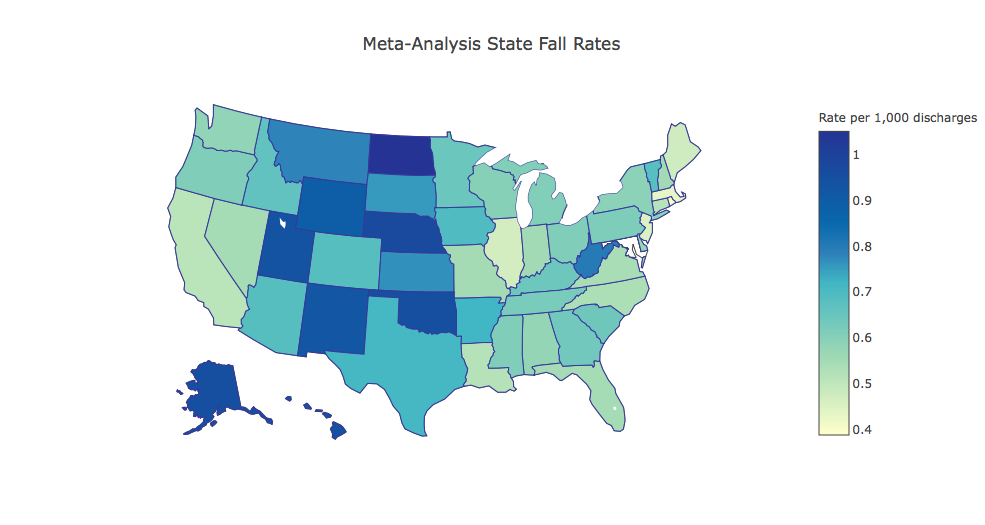

In [102]:
meta_state_fall_image = IPython.display.Image(filename='meta_state_fall.png')
meta_state_fall_image

# Gathering and Exploring Features

## Trauma Data

Here is the trauma data that I scraped from the American College of Surgeons. Here you will see me take the data that I scraped and clean it into a dataset where each hospital has a separate column for its city, state, adult and pediatric trauma level. Then I will add up the number of trauma hospitals in each state and display it on a choropleth map.

In [103]:
trauma_data = pd.read_json('trauma_data.json', orient='records')
print(trauma_data.shape)
print(trauma_data.head())

(486, 3)
                                             address  \
0  13677 W. McDowell Rd., Suite 201, Goodyear, AZ...   
1           875 8th St. NE, Massillon, OH 44646-3554   
2                One Perkins Square, Akron, OH 44308   
3            4315 Diplomacy Dr., Anchorage, AK 99508   
4  43 New Scotland Ave., Mail Code 194, Albany, N...   

                       hospital                              level  
0            Abrazo West Campus             Level II Trauma Center  
1       Affinity Medical Center            Level III Trauma Center  
2     Akron Children's Hospital   Level II Pediatric Trauma Center  
3  Alaska Native Medical Center             Level II Trauma Center  
4         Albany Medical Center              Level I Trauma Center  


In [104]:
zip_list = []
state_list = []
city_list = []
for each in trauma_data.address:
    zip_code = each.split(" ")[-1]
    zip_list.append(zip_code.split("-")[0])
    state_list.append(each.split(" ")[-2])
    city_list.append(each.split(",")[-2])

In [105]:
trauma_data['state'] = state_list
trauma_data['city'] = city_list

In [106]:
trauma_data = trauma_data.drop('address',axis=1)

In [107]:
adult_list = []
for each in trauma_data.level:
    if 'Pediatric' in each:
        if len(each.split(',')) > 1:
               adult_list.append(each.split(",")[0])
        else:
            adult_list.append(None)
    else:
        adult_list.append(each)

In [108]:
for i in range(len(adult_list)):
    if adult_list[i] != None:
        if "Trauma" in adult_list[i]:
            adult_list[i] = adult_list[i].split('Trauma')[0]
        else:
            adult_list[i] = adult_list[i].split('Adult')[0]

In [109]:
trauma_data['adult_trauma'] = adult_list

In [110]:
ped_list = []
for each in trauma_data.level:
    if 'Pediatric' in each.split(",")[-1]:
        ped_list.append(each.split(",")[-1])
    else:
        ped_list.append(None)

In [111]:
for i in range(len(ped_list)):
    if ped_list[i] != None:
        ped_list[i] = ped_list[i].split('Pediatric')[0]

In [112]:
trauma_data['pediatric_trauma'] = ped_list

In [113]:
trauma_data = trauma_data.drop('level',axis=1)

In [114]:
trauma_data = trauma_data.sort_values(by=['state','city'])

In [115]:
trauma_data.index = range(len(trauma_data.index))

In [116]:
trauma_data['hospital'] = trauma_data.hospital.str.title()
trauma_data['hospital'] = trauma_data.hospital.str.strip()
trauma_data['city'] = trauma_data.city.str.strip()
trauma_data['state'] = trauma_data.state.str.strip()

In [117]:
trauma_data.head()

,hospital,state,city,adult_trauma,pediatric_trauma
0,Alaska Native Medical Center,AK,Anchorage,Level II,None
1,Providence Alaska Medical Center,AK,Anchorage,Level II,Level II
2,University Of Alabama At Birmingham Hospital,AL,Birmingham,Level I,None
3,Arkansas Children'S Hospital,AR,Little Rock,None,Level I
4,University Of Arkansas For Medical Sciences,AR,Little Rock,Level I,None


In [118]:
# Here I am saving this dataset to a csv file. 
trauma_data.to_csv('trauma_data.csv', index=False)

Here I am add up the total number of trauma centers in each state and if a state is missing then I am making it equal to the average number of trauma centers per state. 

In [119]:
trauma_dictionary = {}
for each in fall_data.state.unique():
    number_hospitals = 0
    for i in range(len(trauma_data)):
        if trauma_data.state[i] == each:
            number_hospitals += 1
            trauma_dictionary[each] = number_hospitals
    if each not in trauma_data.state.unique():
        trauma_dictionary[each] = 10

In [120]:
state_trauma = pd.DataFrame()
state_trauma['state'] = trauma_dictionary.keys()
state_trauma['trauma_hospital_number'] = trauma_dictionary.values()

In [121]:
# Here I am saving this dataset to a csv file. 
state_trauma.to_csv('state_trauma.csv', index=False)

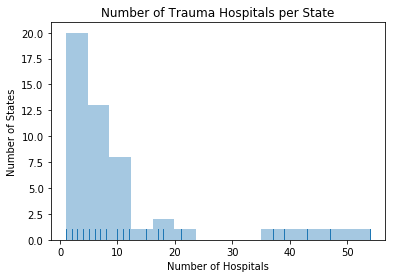

In [122]:
fig = sns.distplot(state_trauma.trauma_hospital_number, kde=False, rug=True)
plt.xlabel("Number of Hospitals")
plt.ylabel("Number of States")
plt.title('Number of Trauma Hospitals per State')
plt.show(fig)

In [123]:
scl = [[0.0, 'rgb(255, 255, 204)'],[0.25, 'rgb(161, 218, 180)'],[0.5, 'rgb(65, 182, 196)'],\
            [0.6, 'rgb(44, 127, 184)'],[0.7, 'rgb(8, 104, 172)'],[1.0, 'rgb(37, 52, 148)']]


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_trauma.state,
        z = state_trauma.trauma_hospital_number,
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(55,55,155)',
                width = 1
            ) ),
        colorbar = dict(
            title = "Number of Hospitals")
        ) ]

layout = dict(
        title = 'Number of Trauma Hospitals',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot(fig)

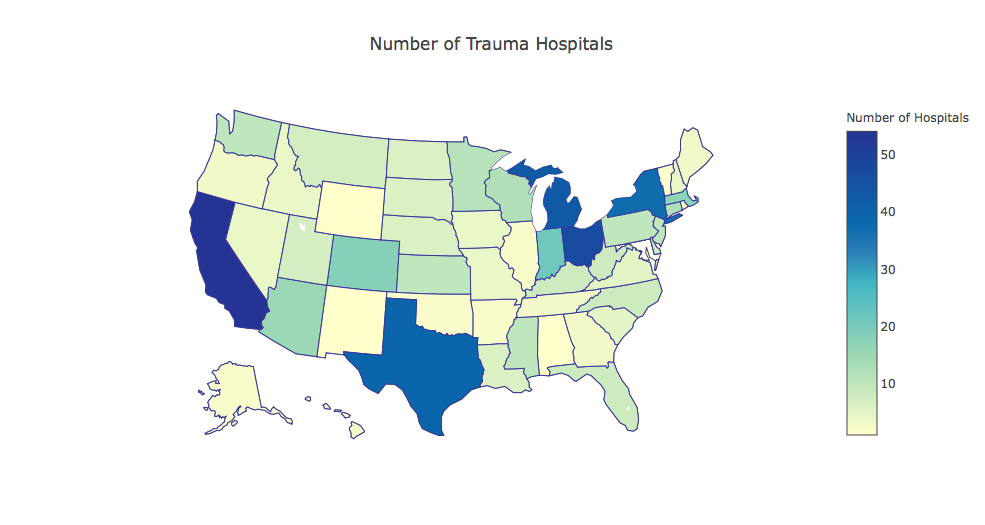

In [124]:
trauma_hospital_image = IPython.display.Image(filename='Trauma_hospitals.png')
trauma_hospital_image

## Healthcare Worker Injury Rates

This is data on the rate of employee injury in the healthcare industry that I downloaded from the Bureau of Labor Statistics State Occupational Injuries, Illnesses, and Fatalities. Here I will clean the data to where each state's injury rates have been averaged separately and for missing states the overall average for each category of injury is applied to it. I will again choropleth map of the healthcare worker injury rates in the United States. 

In [125]:
hospital_state = []
hospital_data = []

def scan_folder(parent):
    
    # iterate over all the files in directory 'parent'
    for subdir, dirs, files in os.walk(parent):
        for file in files:
            #print(file)
            file_name = '/Users/carleyfletcher/industry_injury/' + file

            xl = pd.ExcelFile(file_name)

            title_data = xl.parse()

            state = title_data.columns[0].split(",")[-2]
            hospital_state.append(state)

            # Load a sheet into a DataFrame by name: file_load
            file_load = xl.parse(header=2)
            file_load = file_load.drop('NAICS code3', axis=1)
            file_load = file_load.dropna()
            file_load['Industry2'] = file_load['Industry2'].str.strip()

            hospital_data.append(file_load[file_load['Industry2'] == 'Hospitals'])

scan_folder("/Users/carleyfletcher/industry_injury")

In [126]:
total_recordable_cases = {}
for i in range(len(hospital_data)):
    temp_list = []
    for each in hospital_data[i]['Total recordable cases']:
        temp_list.append(each)
    total_recordable_cases[hospital_state[i]] = temp_list
    
total_recordable = []
for each in total_recordable_cases.values():
    if '-' in each:
        while '-' in each: each.remove('-')
        if len(each) == 0:
            total_recordable.append(0)
        else:
            total_recordable.append(round(sum(each)/len(each),1))
    else:
        total_recordable.append(round(sum(each)/len(each),1))

In [127]:
total = {}
for i in range(len(hospital_data)):
    temp_list = []
    for each in hospital_data[i]['Total']:
        temp_list.append(each)
    total[hospital_state[i]] = temp_list
    
total_list = []
for each in total.values():
    if '-' in each:
        while '-' in each: each.remove('-')
        if len(each) == 0:
            total_list.append(0)
        else:
            total_list.append(round(sum(each)/len(each),1))
    else:
        total_list.append(round(sum(each)/len(each),1))

In [128]:
cases_away_work = {}
for i in range(len(hospital_data)):
    temp_list = []
    for each in hospital_data[i]['Cases with days away from work4']:
        temp_list.append(each)
    cases_away_work[hospital_state[i]] = temp_list
    
cases_away = []
for each in cases_away_work.values():
    if '-' in each:
        while '-' in each: each.remove('-')
        if len(each) == 0:
            cases_away.append(0)
        else:
            cases_away.append(round(sum(each)/len(each),1))
    else:
        cases_away.append(round(sum(each)/len(each),1))

In [129]:
job_transfer_restriction = {}
for i in range(len(hospital_data)):
    temp_list = []
    for each in hospital_data[i]['Cases with job transfer or restriction']:
        temp_list.append(each)
    job_transfer_restriction[hospital_state[i]] = temp_list
    
job_transfer = []
for each in job_transfer_restriction.values():
    if '-' in each:
        while '-' in each: each.remove('-')
        if len(each) == 0:
            job_transfer.append(0)
        else:
            job_transfer.append(round(sum(each)/len(each),1))
    else:
        job_transfer.append(round(sum(each)/len(each),1))

In [130]:
other_cases = {}
for i in range(len(hospital_data)):
    temp_list = []
    for each in hospital_data[i]['Other recordable cases']:
        temp_list.append(each)
    other_cases[hospital_state[i]] = temp_list

other_list = []
for each in other_cases.values():
    if '-' in each:
        while '-' in each: each.remove('-')
        if len(each) == 0:
            other_list.append(0)
        else:
            other_list.append(round(sum(each)/len(each),1))
    else:
        other_list.append(round(sum(each)/len(each),1))

In [131]:
state_list = []
for each in hospital_state:
    state_list.append(each.strip())

In [132]:
worker_injury = pd.DataFrame()

In [133]:
worker_injury['state'] = state_list
worker_injury['total_recordable_cases'] = total_recordable
worker_injury['total_cases'] = total_list
worker_injury['cases_away_work'] = cases_away
worker_injury['job_transfer_restriction'] = job_transfer
worker_injury['other_cases'] = other_list

In [134]:
state_dict = {'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AZ': 'Arizona','CA': 'California', 'CO': 'Colorado',
              'CT': 'Connecticut', 'DC': 'District of Columbia','DE': 'Delaware', 'FL':'Florida', 'GA': 'Georgia',
              'HI': 'Hawaii','IA': 'Iowa','ID':'Idaho', 'IL': 'Illinois','IN': 'Indiana','KS': 'Kansas',
              'KY': 'Kentucky','LA': 'Louisiana','MA': 'Massachusetts','MD': 'Maryland', 'ME': 'Maine',
              'MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri','MT': 'Montana', 'MS':'Mississippi',
              'NC': 'North Carolina', 'ND':'North Dakota','NE': 'Nebraska', 'NH':'New Hampshire','NJ': 'New Jersey',
              'NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio', 'OK':'Oklahoma','OR': 'Oregon',
              'PA': 'Pennsylvania','PR': 'Puerto Rico', 'RI':'Rhode Island','SC': 'South Carolina','SD':'South Dakota','TN': 'Tennessee',
              'TX': 'Texas','UT': 'Utah','VA': 'Virginia','VT': 'Vermont','VI': 'Virgin Islands','WA': 'Washington',
              'WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'}

In [135]:
complete_worker_injury = pd.DataFrame()

In [136]:
complete_worker_injury['state'] = state_dict.values()
complete_worker_injury['total_recordable_cases'] = None
complete_worker_injury['total_cases'] = None
complete_worker_injury['cases_away_work'] = None
complete_worker_injury['job_transfer_restriction'] = None
complete_worker_injury['other_cases'] = None

In [137]:
for i in range(len(complete_worker_injury)):
    if complete_worker_injury.state[i].strip() in state_list:
        for j in range(len(worker_injury)):
            if worker_injury.state[j] == complete_worker_injury.state[i]:
                complete_worker_injury.loc[i, 'total_recordable_cases'] = worker_injury.total_recordable_cases[j]
                complete_worker_injury.loc[i, 'total_cases'] = worker_injury.total_cases[j]
                complete_worker_injury.loc[i, 'cases_away_work'] = worker_injury.cases_away_work[j]
                complete_worker_injury.loc[i, 'job_transfer_restriction'] = worker_injury.job_transfer_restriction[j]
                complete_worker_injury.loc[i, 'other_cases'] = worker_injury.other_cases[j]
    else:
        complete_worker_injury.loc[i, 'total_recordable_cases'] = round(sum(worker_injury.total_recordable_cases)/len(worker_injury.total_recordable_cases),1)
        complete_worker_injury.loc[i, 'total_cases'] = round(sum(worker_injury.total_cases)/len(worker_injury.total_cases),1)
        complete_worker_injury.loc[i, 'cases_away_work'] = round(sum(worker_injury.cases_away_work)/len(worker_injury.cases_away_work),1)
        complete_worker_injury.loc[i, 'job_transfer_restriction'] = round(sum(worker_injury.job_transfer_restriction)/len(worker_injury.job_transfer_restriction),1)
        complete_worker_injury.loc[i, 'other_cases'] = round(sum(worker_injury.other_cases)/len(worker_injury.other_cases),1)

In [138]:
for i in range(len(complete_worker_injury.state)):
    for each in state_dict.keys():
        if complete_worker_injury.state[i]== state_dict[each]:
            complete_worker_injury.loc[i, 'state'] = each

In [139]:
complete_worker_injury.head()

,state,total_recordable_cases,total_cases,cases_away_work,job_transfer_restriction,other_cases
0,AK,7.2,2.5,2.1,0.5,4.6
1,AL,6.2,1.8,0.8,1,4.3
2,AR,4.2,1.2,0.7,0.8,3
3,AZ,5.2,2.3,1.2,1.1,3
4,CA,7.6,4.1,2.4,1.7,3.5


In [140]:
# Here I am saving this dataset to a csv file.
complete_worker_injury.to_csv('complete_worker_injury.csv', index=False)

In [142]:
complete_worker_injury = pd.read_csv('complete_worker_injury.csv')

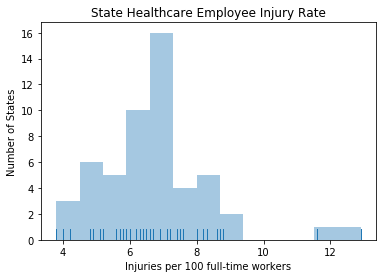

In [143]:
fig = sns.distplot(complete_worker_injury.total_recordable_cases, kde=False, rug=True)
plt.xlabel("Injuries per 100 full-time workers")
plt.ylabel("Number of States")
plt.title('State Healthcare Employee Injury Rate')
plt.show(fig)

In [144]:
plotly.tools.set_credentials_file(username='clfletch', api_key='DJ2OBXydAg87vvpWQKcY')


scl = [[0.0, 'rgb(255, 255, 204)'],[0.25, 'rgb(161, 218, 180)'],[0.5, 'rgb(65, 182, 196)'],\
            [0.6, 'rgb(44, 127, 184)'],[0.7, 'rgb(8, 104, 172)'],[1.0, 'rgb(37, 52, 148)']]


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = complete_worker_injury.state,
        z = complete_worker_injury.total_recordable_cases.astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(55,55,155)',
                width = 1
            ) ),
        colorbar = dict(
            title = "Injuries per 100 full-time workers")
        ) ]

layout = dict(
        title = 'Healthcare Worker Injury Rates',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot(fig)

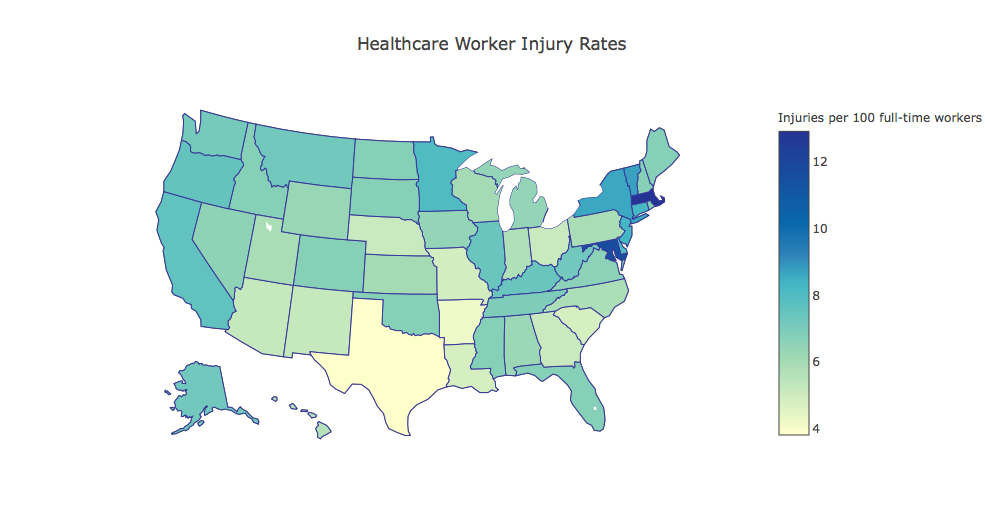

In [145]:
worker_injury_image = IPython.display.Image(filename='worker_injury.png')
worker_injury_image

## 500 Cities Data

This is a dataset from the Center of Disease Control's 500 Cities Project. This project provides small area estimates for chronic disease risk factors, health outcomes, and clinical preventive service use for the largest 500 cities in the United States. I will clean this data to include only the features that I believe will contribute to my model. Then in order to visualize the distribution of these features across the United States, I will average each feature on a state level. 

In [146]:
city_locations = IPython.display.Image(url='https://www.cdc.gov/500cities/images/500-cities-map-734w.png')

In [147]:
city_locations

In [148]:
city_data = pd.read_csv('500_Cities__City-level_Data__GIS_Friendly_Format___2016_release.csv')
print(city_data.shape)
print(city_data.iloc[:, 0:5].head())

(500, 117)
  StateAbbr   PlaceName  PlaceFIPS  Population2010  ACCESS2_CrudePrev
0        AL  Birmingham     107000          212237               22.6
1        AL      Hoover     135896           81619               10.6
2        AL  Huntsville     137000          180105               17.4
3        AL      Mobile     150000          195111               20.0
4        AL  Montgomery     151000          205764               19.7


In [149]:
city_data.columns

Index(['StateAbbr', 'PlaceName', 'PlaceFIPS', 'Population2010',
       'ACCESS2_CrudePrev', 'ACCESS2_Crude95CI', 'ACCESS2_AdjPrev',
       'ACCESS2_Adj95CI', 'ARTHRITIS_CrudePrev', 'ARTHRITIS_Crude95CI',
       ...
       'SLEEP_Adj95CI', 'STROKE_CrudePrev', 'STROKE_Crude95CI',
       'STROKE_AdjPrev', 'STROKE_Adj95CI', 'TEETHLOST_CrudePrev',
       'TEETHLOST_Crude95CI', 'TEETHLOST_AdjPrev', 'TEETHLOST_Adj95CI',
       'Geolocation'],
      dtype='object', length=117)

In [150]:
city_data = city_data.loc[:, ['StateAbbr', 'PlaceName', 'Population2010', 'ARTHRITIS_CrudePrev','BINGE_CrudePrev',
                              'OBESITY_CrudePrev','SLEEP_CrudePrev','STROKE_CrudePrev']]

In [151]:
city_data.head()

,StateAbbr,PlaceName,Population2010,ARTHRITIS_CrudePrev,BINGE_CrudePrev,OBESITY_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev
0,AL,Birmingham,212237,32.6,11.5,38.2,46.5,5.0
1,AL,Hoover,81619,26.3,15.4,25.0,34.6,2.3
2,AL,Huntsville,180105,30.0,12.2,31.4,39.2,3.3
3,AL,Mobile,195111,33.1,12.5,37.0,41.6,4.3
4,AL,Montgomery,205764,31.0,12.5,36.3,41.1,4.0


In [152]:
# Here I am saving this dataset to a csv file.
city_data.to_csv('city_data.csv', index=False)

In [153]:
from collections import defaultdict
city_dictionary = defaultdict(list)
for each in city_data.StateAbbr.unique():
    pop_average = 0
    arthritis_average = 0
    binge_average = 0
    obesity_average = 0
    sleep_average = 0
    stroke_average = 0
    city_number = 0
    for i in range(len(city_data)):
        if city_data.StateAbbr[i] == each:
            pop_average += city_data.Population2010[i]
            arthritis_average = city_data.ARTHRITIS_CrudePrev[i]
            binge_average = city_data.BINGE_CrudePrev[i]
            obesity_average = city_data.OBESITY_CrudePrev[i]
            sleep_average = city_data.SLEEP_CrudePrev[i]
            stroke_average = city_data.STROKE_CrudePrev[i]
            city_number += 1
    pop_average = round(pop_average/city_number,3)
    arthritis_average = round(arthritis_average/city_number,3)
    binge_average = round(binge_average/city_number,3)
    obesity_average = round(obesity_average/city_number,3)
    sleep_average = round(sleep_average/city_number,3)
    stroke_average = round(stroke_average/city_number,3)
    city_dictionary[each].append(pop_average) 
    city_dictionary[each].append(arthritis_average)
    city_dictionary[each].append(binge_average)
    city_dictionary[each].append(obesity_average)
    city_dictionary[each].append(sleep_average)
    city_dictionary[each].append(stroke_average)

In [154]:
city_dictionary

defaultdict(list,
            {'AK': [291826.0, 19.3, 21.6, 27.8, 34.0, 2.2],
             'AL': [160884.0, 4.133, 2.4, 5.567, 6.583, 0.517],
             'AR': [98074.6, 4.76, 2.98, 6.86, 7.34, 0.62],
             'AZ': [324672.833, 1.833, 1.3, 2.692, 2.95, 0.258],
             'CA': [184855.521, 0.152, 0.142, 0.21, 0.29, 0.02],
             'CO': [179308.786, 1.457, 1.386, 1.607, 2.1, 0.15],
             'CT': [108936.75, 3.262, 1.712, 4.275, 5.212, 0.438],
             'DC': [601723.0, 19.2, 21.9, 24.2, 34.9, 3.1],
             'DE': [70851.0, 25.7, 15.1, 38.9, 44.2, 4.1],
             'FL': [156560.212, 0.764, 0.473, 0.809, 1.209, 0.109],
             'GA': [141070.0, 2.218, 1.3, 3.027, 3.736, 0.291],
             'HI': [953207.0, 18.8, 18.4, 21.8, 47.4, 2.7],
             'IA': [108066.0, 4.383, 3.433, 5.783, 5.483, 0.567],
             'ID': [120773.333, 7.867, 4.967, 11.5, 11.433, 1.033],
             'IL': [247088.444, 1.161, 0.983, 1.967, 2.106, 0.172],
             'IN': [166

In [155]:
state_averages = pd.DataFrame.from_dict(city_dictionary, orient='index')

In [156]:
state_averages = state_averages.reset_index(level=0)

In [157]:
state_averages.columns = ['state', 'pop_average', 'arthritis_average', 'binge_average', 'obesity_average', 'sleep_average', 'stroke_average']

In [158]:
state_averages.head()

,state,pop_average,arthritis_average,binge_average,obesity_average,sleep_average,stroke_average
0,AL,160884.000,4.133,2.400,5.567,6.583,0.517
1,AK,291826.000,19.300,21.600,27.800,34.000,2.200
2,AZ,324672.833,1.833,1.300,2.692,2.950,0.258
3,AR,98074.600,4.760,2.980,6.860,7.340,0.620
4,CA,184855.521,0.152,0.142,0.210,0.290,0.020


In [159]:
# Here I am saving this dataset to a csv file.
state_averages.to_csv('state_averages.csv', index=False)

In [160]:
plotly.tools.set_credentials_file(username='clfletch', api_key='DJ2OBXydAg87vvpWQKcY')


scl = [[0.0, 'rgb(255, 255, 204)'],[0.25, 'rgb(161, 218, 180)'],[0.5, 'rgb(65, 182, 196)'],\
            [0.6, 'rgb(44, 127, 184)'],[0.7, 'rgb(8, 104, 172)'],[1.0, 'rgb(37, 52, 148)']]


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_averages.state,
        z = state_averages.arthritis_average,
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(55,55,155)',
                width = 1
            ) ),
        colorbar = dict(
            title = "Percentage/Prevalence")
        ) ]

layout = dict(
        title = 'State Arthritis Prevalence',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )

fig = dict( data=data, layout=layout )
py.iplot(fig)

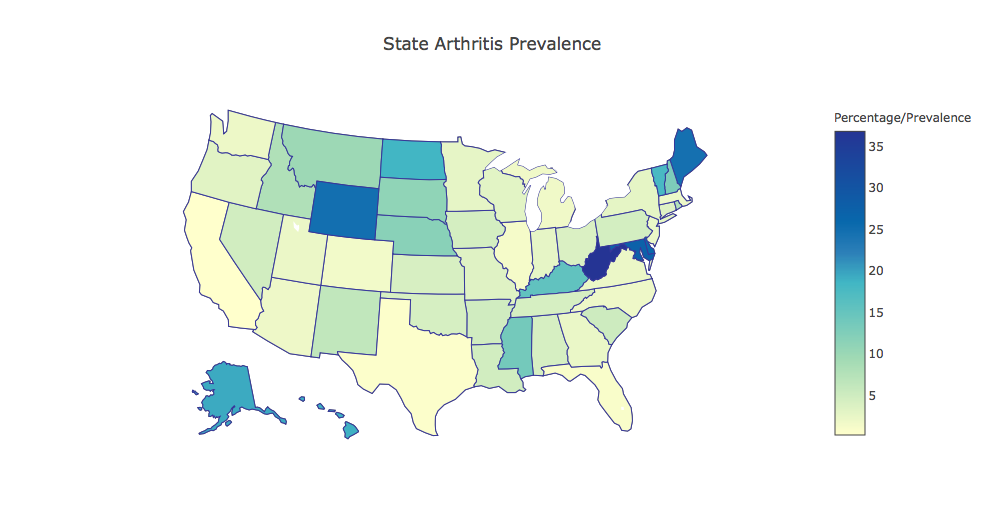

In [161]:
state_arthritis_image = IPython.display.Image(filename='state_arthritis.png')
state_arthritis_image

In [162]:
plotly.tools.set_credentials_file(username='clfletch', api_key='DJ2OBXydAg87vvpWQKcY')


scl = [[0.0, 'rgb(255, 255, 204)'],[0.25, 'rgb(161, 218, 180)'],[0.5, 'rgb(65, 182, 196)'],\
            [0.6, 'rgb(44, 127, 184)'],[0.7, 'rgb(8, 104, 172)'],[1.0, 'rgb(37, 52, 148)']]


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_averages.state,
        z = state_averages.binge_average,
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(55,55,155)',
                width = 1
            ) ),
        colorbar = dict(
            title = "Percentage/Prevalence")
        ) ]

layout = dict(
        title = 'State Binge Drinking Prevalence',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )

fig = dict( data=data, layout=layout )
py.iplot(fig)

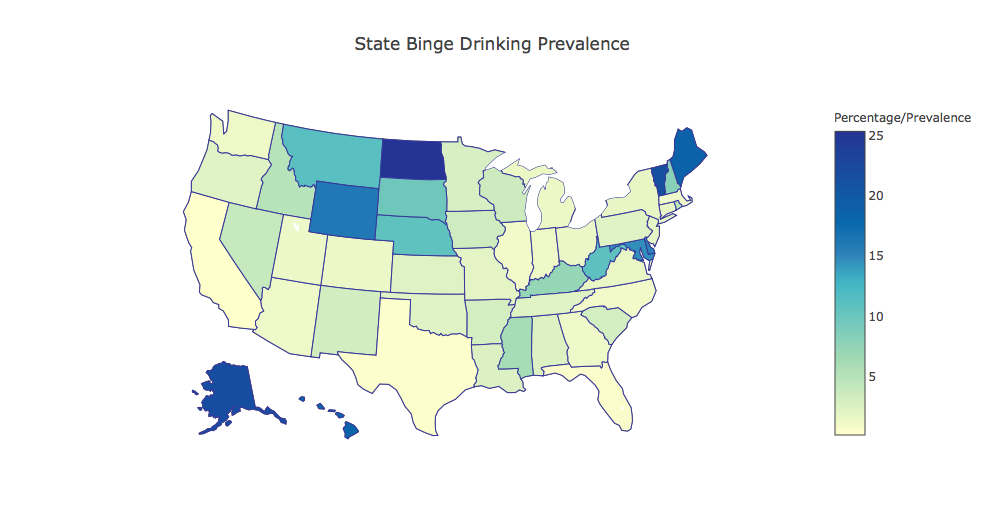

In [163]:
state_binge_image = IPython.display.Image(filename='state_binge.png')
state_binge_image

In [164]:
plotly.tools.set_credentials_file(username='clfletch', api_key='DJ2OBXydAg87vvpWQKcY')


scl = [[0.0, 'rgb(255, 255, 204)'],[0.25, 'rgb(161, 218, 180)'],[0.5, 'rgb(65, 182, 196)'],\
            [0.6, 'rgb(44, 127, 184)'],[0.7, 'rgb(8, 104, 172)'],[1.0, 'rgb(37, 52, 148)']]


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_averages.state,
        z = state_averages.obesity_average,
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(55,55,155)',
                width = 1
            ) ),
        colorbar = dict(
            title = "Percentage/Prevalence")
        ) ]

layout = dict(
        title = 'State Obesity Prevalence',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )

fig = dict( data=data, layout=layout )
py.iplot(fig)

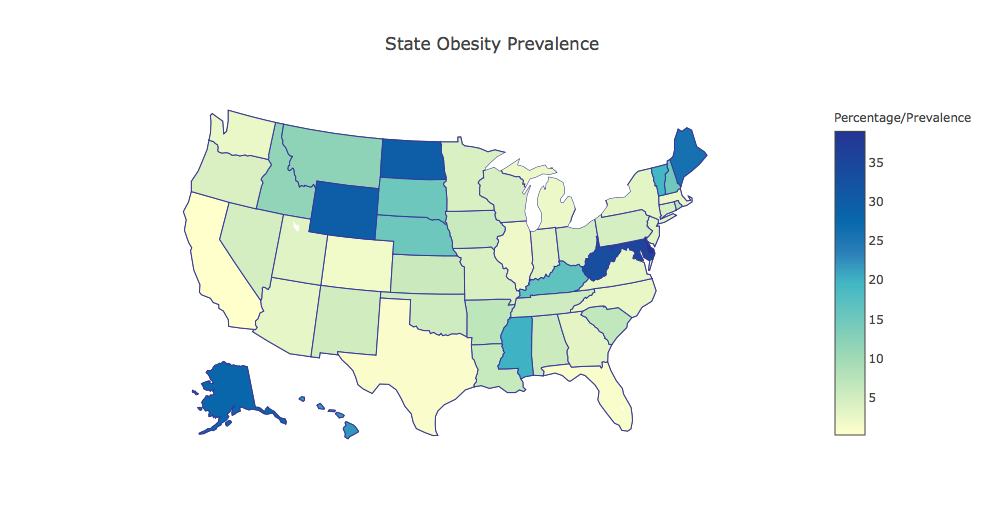

In [165]:
state_obesity_image = IPython.display.Image(filename='state_obesity.png')
state_obesity_image

In [166]:
plotly.tools.set_credentials_file(username='clfletch', api_key='DJ2OBXydAg87vvpWQKcY')


scl = [[0.0, 'rgb(255, 255, 204)'],[0.25, 'rgb(161, 218, 180)'],[0.5, 'rgb(65, 182, 196)'],\
            [0.6, 'rgb(44, 127, 184)'],[0.7, 'rgb(8, 104, 172)'],[1.0, 'rgb(37, 52, 148)']]


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_averages.state,
        z = state_averages.sleep_average,
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(55,55,155)',
                width = 1
            ) ),
        colorbar = dict(
            title = "Percentage/Prevalence")
        ) ]

layout = dict(
        title = 'State Prevalence Sleeping less than 7 hours daily',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )

fig = dict( data=data, layout=layout )
py.iplot(fig)

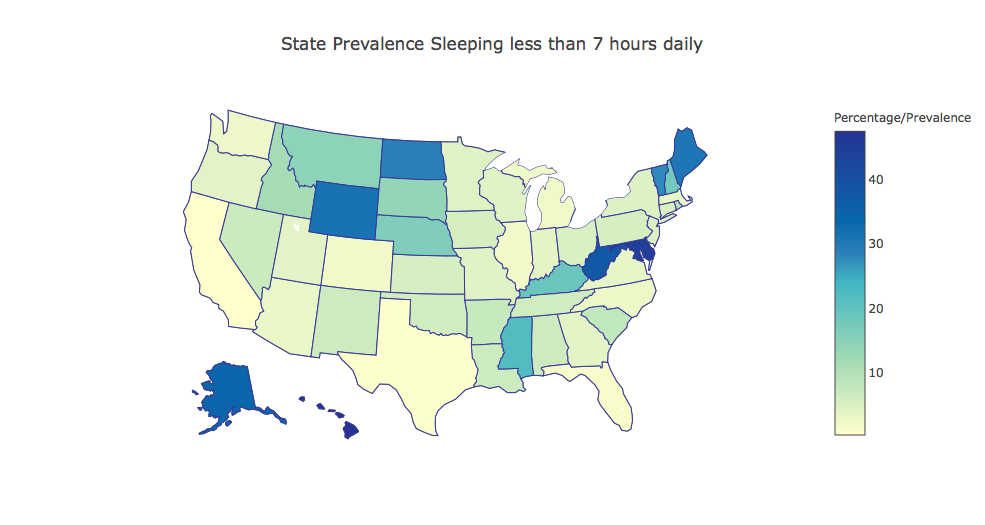

In [167]:
state_sleep_image = IPython.display.Image(filename='state_sleep.png')
state_sleep_image

In [168]:
plotly.tools.set_credentials_file(username='clfletch', api_key='DJ2OBXydAg87vvpWQKcY')


scl = [[0.0, 'rgb(255, 255, 204)'],[0.25, 'rgb(161, 218, 180)'],[0.5, 'rgb(65, 182, 196)'],\
            [0.6, 'rgb(44, 127, 184)'],[0.7, 'rgb(8, 104, 172)'],[1.0, 'rgb(37, 52, 148)']]


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_averages.state,
        z = state_averages.stroke_average,
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(55,55,155)',
                width = 1
            ) ),
        colorbar = dict(
            title = "Percentage/Prevalence")
        ) ]

layout = dict(
        title = 'State Stroke Prevalence',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )

fig = dict( data=data, layout=layout )
py.iplot(fig)

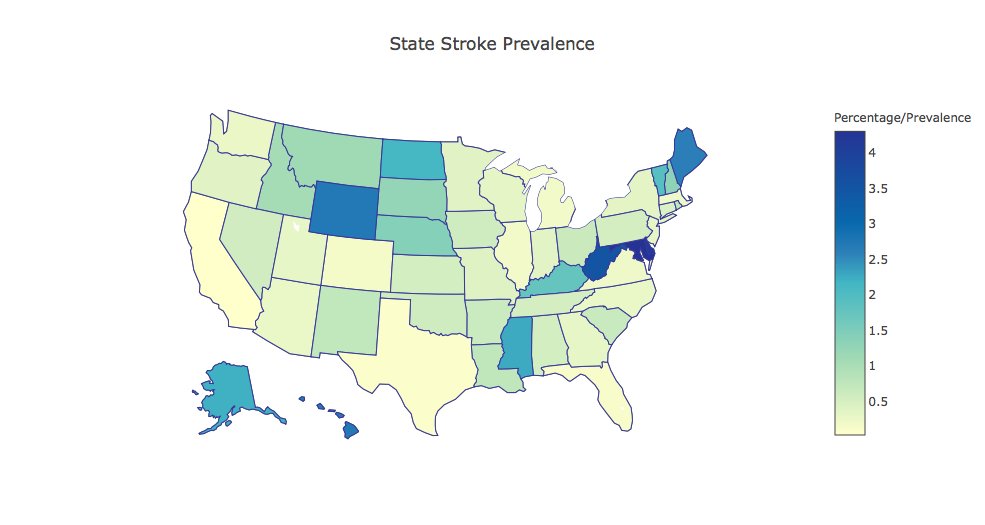

In [169]:
state_stroke_image = IPython.display.Image(filename='state_stroke.png')
state_stroke_image

# Merging Data into one Dataset

Here I am going to create my final dataset where I join the dataset with the hospital and state fall meta-analysis rates with each of the other features that I have scraped or gathered. I will first create a binary feature that will classify a hospital by whether it is an adult or pediatric trauma center. Then I will add the healthcare worker injury rates for each state to the dataset. And lastly, I will limit my final dataset to hospitals that are located in one of the 500 cities that I have health statistics about.  

In [170]:
print(complete_data.shape)
complete_data.head()

(2069, 5)


,hospital,state,city,meta_hospital_fall,meta_state_fall
0,Alaska Native Medical Center,AK,Anchorage,1.4280,0.9495
1,Yukon Kuskokwim Delta Reg Hospital,AK,Bethel,0.8710,0.9495
2,Fairbanks Memorial Hospital,AK,Fairbanks,0.7635,0.9495
3,Shelby Baptist Medical Center,AL,Alabaster,0.2765,0.5760
4,Russell Hospital,AL,Alexander City,0.4655,0.5760


In [171]:
complete_data['adult_trauma'] = 0
complete_data['pediatric_trauma'] = 0
words_list = ['Hospital', 'Medical', 'Center', 'Health', 'System', 'Hospitals', 'Foundation', 'Kaiser']
for i in range(len(complete_data)):
    for j in range(len(trauma_data)):
        if (complete_data.state[i] == trauma_data.state[j]) and (complete_data.city[i] == trauma_data.city[j]):
            list_one = complete_data.hospital[i].split()
            list_two = trauma_data.hospital[j].split()
            together = list(set(list_one) & set(list_two) - set(words_list))
            if len(together) >= 1:
                if trauma_data.adult_trauma[j] != None:
                    complete_data.loc[i, 'adult_trauma'] = 1
                elif trauma_data.pediatric_trauma[j] != None:
                    complete_data.loc[i, 'pediatric_trauma'] = 1
                break

In [172]:
#Here I am saving this dataset to a csv file. 
complete_data.to_csv('complete_trauma.csv', index=False)

In [173]:
print(complete_data.shape)
complete_data.head()

(2069, 7)


,hospital,state,city,meta_hospital_fall,meta_state_fall,adult_trauma,pediatric_trauma
0,Alaska Native Medical Center,AK,Anchorage,1.4280,0.9495,1,0
1,Yukon Kuskokwim Delta Reg Hospital,AK,Bethel,0.8710,0.9495,0,0
2,Fairbanks Memorial Hospital,AK,Fairbanks,0.7635,0.9495,0,0
3,Shelby Baptist Medical Center,AL,Alabaster,0.2765,0.5760,0,0
4,Russell Hospital,AL,Alexander City,0.4655,0.5760,0,0


In [174]:
complete_data = pd.merge(complete_data, complete_worker_injury, on='state')

In [175]:
complete_data = complete_data.drop(['total_cases', 'cases_away_work', 'job_transfer_restriction', 'other_cases'], axis=1)

In [176]:
#Here I am saving this dataset to a csv file. 
complete_data.to_csv('complete_injury.csv', index=False)

In [177]:
print(complete_data.shape)
complete_data.head()

(2069, 8)


,hospital,state,city,meta_hospital_fall,meta_state_fall,adult_trauma,pediatric_trauma,total_recordable_cases
0,Alaska Native Medical Center,AK,Anchorage,1.4280,0.9495,1,0,7.2
1,Yukon Kuskokwim Delta Reg Hospital,AK,Bethel,0.8710,0.9495,0,0,7.2
2,Fairbanks Memorial Hospital,AK,Fairbanks,0.7635,0.9495,0,0,7.2
3,Shelby Baptist Medical Center,AL,Alabaster,0.2765,0.5760,0,0,6.2
4,Russell Hospital,AL,Alexander City,0.4655,0.5760,0,0,6.2


In [178]:
city_data.head()

,StateAbbr,PlaceName,Population2010,ARTHRITIS_CrudePrev,BINGE_CrudePrev,OBESITY_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev
0,AL,Birmingham,212237,32.6,11.5,38.2,46.5,5.0
1,AL,Hoover,81619,26.3,15.4,25.0,34.6,2.3
2,AL,Huntsville,180105,30.0,12.2,31.4,39.2,3.3
3,AL,Mobile,195111,33.1,12.5,37.0,41.6,4.3
4,AL,Montgomery,205764,31.0,12.5,36.3,41.1,4.0


In [179]:
city_data.rename(columns={'PlaceName':'city', 'StateAbbr': 'state'}, inplace=True)

In [180]:
complete_data = pd.merge(complete_data, city_data, on='city')

In [181]:
for i in range(len(complete_data)):
    if complete_data.state_x[i] != complete_data.state_y[i]:
        complete_data.drop(i, inplace=True)

In [182]:
complete_data.index = range(len(complete_data.index))

In [183]:
complete_data = complete_data.drop(['state_y'], axis=1)
complete_data.rename(columns={'state_x': 'state'}, inplace=True)

In [184]:
print(complete_data.shape)
complete_data.head()

(796, 14)


,hospital,state,city,meta_hospital_fall,meta_state_fall,adult_trauma,pediatric_trauma,total_recordable_cases,Population2010,ARTHRITIS_CrudePrev,BINGE_CrudePrev,OBESITY_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev
0,Alaska Native Medical Center,AK,Anchorage,1.428,0.9495,1,0,7.2,291826,19.3,21.6,27.8,34.0,2.2
1,University Of Alabama Hospital,AL,Birmingham,0.359,0.5760,1,0,6.2,212237,32.6,11.5,38.2,46.5,5.0
2,Princeton Baptist Medical Center,AL,Birmingham,0.524,0.5760,0,0,6.2,212237,32.6,11.5,38.2,46.5,5.0
3,Brookwood Baptist Medical Center,AL,Birmingham,0.366,0.5760,0,0,6.2,212237,32.6,11.5,38.2,46.5,5.0
4,St Marys Hospital,IL,Decatur,0.959,0.4655,0,0,7.4,76122,29.9,17.1,34.4,35.5,4.0


# Modeling and Clustering

Now that I have my final dataset I will perform one more clustering and move onto modeling with my dataset. 

In [185]:
complete_data.dtypes

hospital                   object
state                      object
city                       object
meta_hospital_fall        float64
meta_state_fall           float64
adult_trauma                int64
pediatric_trauma            int64
total_recordable_cases    float64
Population2010              int64
ARTHRITIS_CrudePrev       float64
BINGE_CrudePrev           float64
OBESITY_CrudePrev         float64
SLEEP_CrudePrev           float64
STROKE_CrudePrev          float64
dtype: object

In [186]:
complete_data.total_recordable_cases = complete_data.total_recordable_cases.astype(float)

In [187]:
#Here I am saving this dataset to a csv file. 
complete_data.to_csv('complete_fall_data.csv', index=False)

In [188]:
complete_data.describe()

,meta_hospital_fall,meta_state_fall,adult_trauma,pediatric_trauma,total_recordable_cases,Population2010,ARTHRITIS_CrudePrev,BINGE_CrudePrev,OBESITY_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev
count,796.000000,796.000000,796.000000,796.000000,796.000000,7.960000e+02,796.000000,796.000000,796.000000,796.000000,796.000000
mean,0.591928,0.611136,0.326633,0.017588,6.349497,5.518945e+05,22.685427,16.641080,30.005528,36.280025,3.023744
std,0.609685,0.123058,0.469277,0.131531,1.656734,1.027549e+06,4.180453,2.529267,5.330847,4.348801,0.711806
min,0.038500,0.387000,0.000000,0.000000,3.800000,4.241700e+04,9.400000,9.100000,16.100000,24.400000,1.300000
25%,0.317625,0.508500,0.000000,0.000000,5.100000,1.085000e+05,19.500000,15.100000,26.100000,33.675000,2.575000
50%,0.482500,0.589500,0.000000,0.000000,6.600000,2.089160e+05,22.400000,16.400000,30.600000,36.100000,3.000000
75%,0.648750,0.693000,1.000000,0.000000,7.500000,5.837560e+05,25.400000,18.200000,33.400000,38.600000,3.400000
max,7.249500,1.050500,1.000000,1.000000,12.900000,8.175133e+06,36.800000,25.300000,47.100000,51.300000,6.500000


In [189]:
complete_data.corr()

,meta_hospital_fall,meta_state_fall,adult_trauma,pediatric_trauma,total_recordable_cases,Population2010,ARTHRITIS_CrudePrev,BINGE_CrudePrev,OBESITY_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev
meta_hospital_fall,1.000000,0.229021,-0.069776,-0.057691,-0.133069,-0.067370,-0.003566,-0.029333,0.029045,-0.076335,-0.019783
meta_state_fall,0.229021,1.000000,0.027828,-0.019810,-0.496166,-0.051973,-0.034724,-0.122910,0.117830,-0.209603,-0.086935
adult_trauma,-0.069776,0.027828,1.000000,-0.093189,0.018494,0.033301,-0.017832,0.040397,0.035631,-0.043026,-0.009314
pediatric_trauma,-0.057691,-0.019810,-0.093189,1.000000,0.035252,0.092122,-0.055580,0.035636,-0.053957,-0.011260,-0.036710
total_recordable_cases,-0.133069,-0.496166,0.018494,0.035252,1.000000,0.088824,0.046159,0.077132,-0.287252,0.119122,-0.062778
Population2010,-0.067370,-0.051973,0.033301,0.092122,0.088824,1.000000,-0.162872,0.021018,-0.075839,0.157546,-0.000267
ARTHRITIS_CrudePrev,-0.003566,-0.034724,-0.017832,-0.055580,0.046159,-0.162872,1.000000,-0.386655,0.609555,0.483021,0.790281
BINGE_CrudePrev,-0.029333,-0.122910,0.040397,0.035636,0.077132,0.021018,-0.386655,1.000000,-0.383592,-0.441416,-0.483873
OBESITY_CrudePrev,0.029045,0.117830,0.035631,-0.053957,-0.287252,-0.075839,0.609555,-0.383592,1.000000,0.618345,0.775408
SLEEP_CrudePrev,-0.076335,-0.209603,-0.043026,-0.011260,0.119122,0.157546,0.483021,-0.441416,0.618345,1.000000,0.711483


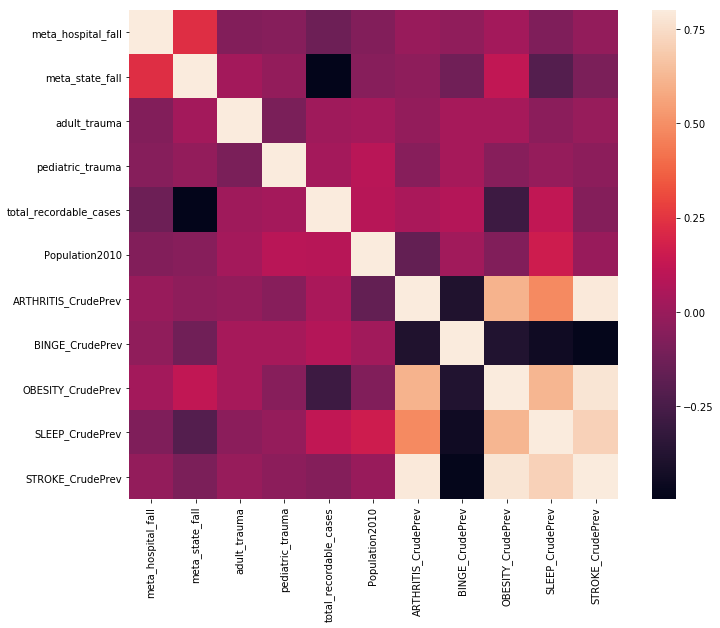

In [190]:
# Make the correlation matrix.
corrmat = complete_data.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [191]:
#Next I isolate only the continuous variables so that I can visualize any correlation. 
continuous = complete_data.loc[:, ['meta_hospital_fall', 'meta_state_fall', 'adult_trauma', 'pediatric_trauma', 
                                   'total_recordable_cases', 'Population2010', 'ARTHRITIS_CrudePrev', 'BINGE_CrudePrev',
                                   'OBESITY_CrudePrev', 'SLEEP_CrudePrev', 'STROKE_CrudePrev']]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


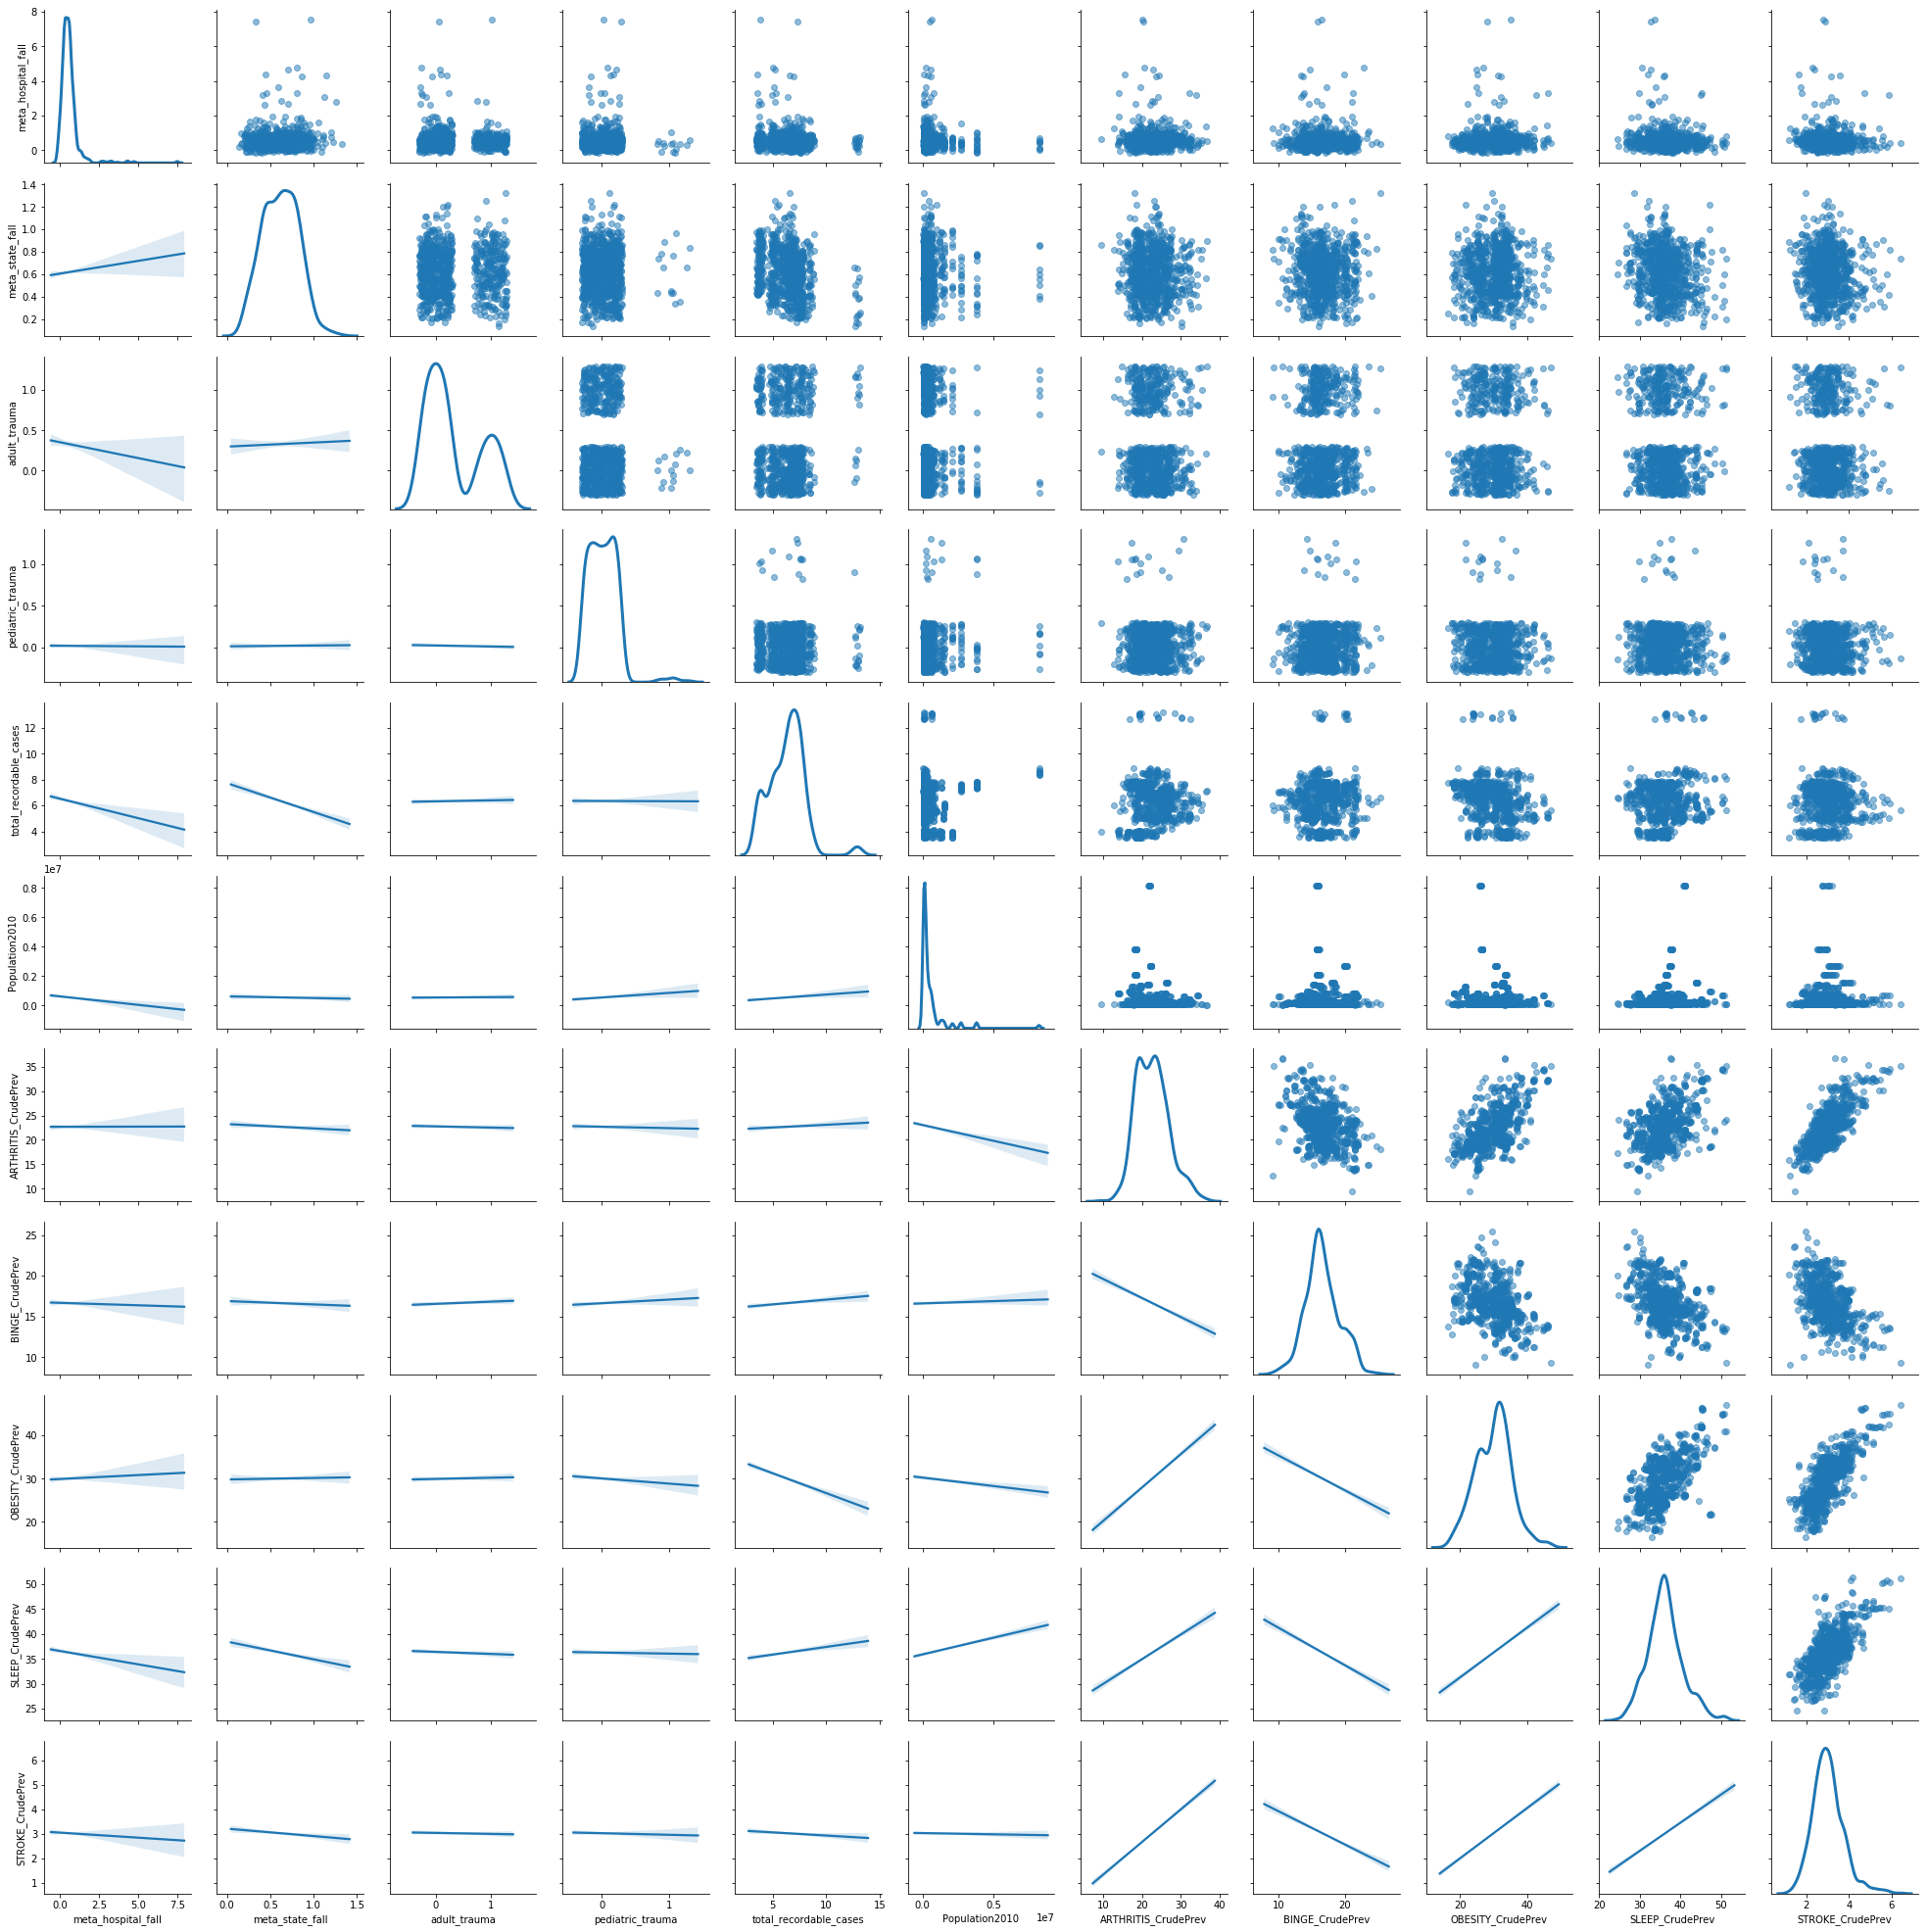

In [192]:
# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(continuous.shape)),
    columns=continuous.columns
)
# Combine the data and the noise.
continuous = continuous.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(continuous.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

In [193]:
complete_data.head()

,hospital,state,city,meta_hospital_fall,meta_state_fall,adult_trauma,pediatric_trauma,total_recordable_cases,Population2010,ARTHRITIS_CrudePrev,BINGE_CrudePrev,OBESITY_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev
0,Alaska Native Medical Center,AK,Anchorage,1.428,0.9495,1,0,7.2,291826,19.3,21.6,27.8,34.0,2.2
1,University Of Alabama Hospital,AL,Birmingham,0.359,0.5760,1,0,6.2,212237,32.6,11.5,38.2,46.5,5.0
2,Princeton Baptist Medical Center,AL,Birmingham,0.524,0.5760,0,0,6.2,212237,32.6,11.5,38.2,46.5,5.0
3,Brookwood Baptist Medical Center,AL,Birmingham,0.366,0.5760,0,0,6.2,212237,32.6,11.5,38.2,46.5,5.0
4,St Marys Hospital,IL,Decatur,0.959,0.4655,0,0,7.4,76122,29.9,17.1,34.4,35.5,4.0


Here I am going to define my dependent outcome and independent features that I will use for all my clustering and modeling. 

In [194]:
#Define the features and the outcome.
X = complete_data.drop(['hospital', 'meta_hospital_fall', 'city'], axis=1)
y = complete_data.meta_hospital_fall

#In order to have the states as a feature I need use get_dummies
X = pd.get_dummies(X)

During this final clustering, my dependent feature will again be a binary version of meta_hospital_fall and the other features that I am going to use are all the remaining features except for hospital, city, and meta_hospital_fall. I decided to separate the binary dependent outcome on hospital fall rates that are greater than 0.6 since 50% of the data is at 0.48 or below. I again chose to separate my data into three clusters for a high, low, and unknown group of hospitals.

In [195]:
#Binarize y so that 1 means a high fall rate and 0 is a low fall rate. 
cluster_y = np.where(y >= 0.6, 1, 0)

#Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X)

#Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, cluster_y))

Comparing k-means clusters against the data:
col_0    0    1
row_0          
0       34    9
1      501  244
2        8    0


In [196]:
complete_data['cluster'] = y_pred 

In [197]:
complete_data.groupby('cluster').meta_hospital_fall.mean()

cluster
0    0.405767
1    0.604834
2    0.390687
Name: meta_hospital_fall, dtype: float64

From this clustering, it appears that cluster 0 and 2 are nearly identical with hospital fall rates of 0.39 while cluster 1 has the highest fall rate of 0.60. The reason for this difference appears to be that almost all the hospitals are clustered into one group. 

## Regression Models

Because my initial goal is to create an explanatory model for hospital fall rates, I am going to use Regression Models with my dataset.

In [198]:
# Random Forest Regression
rfr = ensemble.RandomForestRegressor(n_estimators=50, max_depth=5)
rfr.fit(X, y)
print(rfr)
print('Training set score:', rfr.score(X, y))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Training set score: 0.24233306596234505


In [199]:
RFR_score = cross_val_score(rfr, X, y, cv=5)
print('\nEach Cross Validated R2 score: \n', RFR_score)
print("\nOverall Random Forest Regression R2: %0.2f (+/- %0.2f)\n" % (RFR_score.mean(), RFR_score.std() * 2))


Each Cross Validated R2 score: 
 [-0.01547809 -0.32577172 -1.70205742  0.01457094  0.014419  ]

Overall Random Forest Regression R2: -0.40 (+/- 1.32)



In [200]:
# Saving the feature names
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(rfr.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [201]:
feature_importances = feature_importances[:20]

In [202]:
feature_importances

[('meta_state_fall', 0.17),
 ('Population2010', 0.12),
 ('OBESITY_CrudePrev', 0.11),
 ('adult_trauma', 0.1),
 ('SLEEP_CrudePrev', 0.1),
 ('STROKE_CrudePrev', 0.1),
 ('BINGE_CrudePrev', 0.07),
 ('state_NM', 0.06),
 ('ARTHRITIS_CrudePrev', 0.05),
 ('total_recordable_cases', 0.03),
 ('state_NE', 0.03),
 ('state_CA', 0.02),
 ('state_OH', 0.01),
 ('pediatric_trauma', 0.0),
 ('state_AK', 0.0),
 ('state_AL', 0.0),
 ('state_AR', 0.0),
 ('state_AZ', 0.0),
 ('state_CO', 0.0),
 ('state_CT', 0.0)]

This Random Forest Regression Model performed very poorly. It was affected by over-fitting with a training R-squared score of 0.24 but a cross-validated score of -0.40. I can see that is was largely due to the low number of correlated independent features. 

In [203]:
# Logistic Regression
lr = LinearRegression(n_jobs=20)
lr.fit(X, y)
print(lr)
print('Training set score:', lr.score(X, y))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=20, normalize=False)
Training set score: 0.10898307850282031


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



In [204]:
LR_score = cross_val_score(lr, X, y, cv=5)
print('\nEach Cross Validated R2 score: \n', LR_score)
print("\nOverall Linear Regression R2: %0.2f (+/- %0.2f)\n" % (LR_score.mean(), LR_score.std() * 2))


Each Cross Validated R2 score: 
 [-0.00222326 -0.23515336 -0.19107563  0.01601725 -0.03245238]

Overall Linear Regression R2: -0.09 (+/- 0.21)



Again, this linear regression model performed poorly but it did have less over-fitting that the Random Forest Regression model. 

## Classification Models

Since my regression models performed poorly, I am going to move onto classification models. Similar to my clustering challenge earlier I will change my dependent outcome to a binary feature for high and low fall rates. I will set the threshold at 0.6 because the mean is 0.59 and the 50th percentile is 0.48. 

In [205]:
complete_data.meta_hospital_fall.describe()

count    796.000000
mean       0.591928
std        0.609685
min        0.038500
25%        0.317625
50%        0.482500
75%        0.648750
max        7.249500
Name: meta_hospital_fall, dtype: float64

In [206]:
complete_data['high_low'] = 0
for i in range(len(complete_data)):
    if complete_data.meta_hospital_fall[i] >= 0.6:
        complete_data.loc[i, 'high_low'] = 1

In [207]:
#Define the features and the outcome.
X = complete_data.drop(['hospital', 'meta_hospital_fall', 'high_low', 'city'], axis=1)
y = complete_data.high_low

#In order to have the states as a feature I need use get_dummies
X = pd.get_dummies(X)

In [208]:
# Random Forest Classification
rfc = ensemble.RandomForestClassifier(n_estimators=70, max_depth=10)
rfc.fit(X, y)
print(rfc)
print('Training set score:', rfc.score(X, y))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Training set score: 0.7864321608040201


In [209]:
RFC_score = cross_val_score(rfc, X, y, cv=5)
print('\nEach Cross Validated Accuracy: \n', RFC_score)
print("\nOverall Random Forest Classification Accuracy: %0.2f (+/- %0.2f)\n" % (RFC_score.mean(), RFC_score.std() * 2))


Each Cross Validated Accuracy: 
 [0.68125    0.60625    0.475      0.53797468 0.50632911]

Overall Random Forest Classification Accuracy: 0.56 (+/- 0.15)



In [210]:
print("Report:")
y_true, y_pred = y, rfc.predict(X)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
             precision    recall  f1-score   support

          0       0.77      0.98      0.86       543
          1       0.88      0.38      0.53       253

avg / total       0.81      0.79      0.76       796



array([[530,  13],
       [157,  96]])

In [211]:
# Saving the feature names
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [212]:
feature_importances = feature_importances[:20]

In [213]:
feature_importances

[('Population2010', 0.13),
 ('meta_state_fall', 0.1),
 ('ARTHRITIS_CrudePrev', 0.1),
 ('OBESITY_CrudePrev', 0.1),
 ('SLEEP_CrudePrev', 0.1),
 ('BINGE_CrudePrev', 0.09),
 ('STROKE_CrudePrev', 0.08),
 ('adult_trauma', 0.06),
 ('total_recordable_cases', 0.05),
 ('pediatric_trauma', 0.01),
 ('cluster', 0.01),
 ('state_CO', 0.01),
 ('state_FL', 0.01),
 ('state_KY', 0.01),
 ('state_MI', 0.01),
 ('state_NE', 0.01),
 ('state_OH', 0.01),
 ('state_OK', 0.01),
 ('state_TN', 0.01),
 ('state_TX', 0.01)]

My Random Forest Classification model performed much better than the regression model with some over-fitting but a better accuracy score and fairly good precision and recall scores. From my feature importance, I can see that arthritis, population, and obesity are the three most important features in this model. 

In [214]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(loss = 'deviance', max_depth=10)
clf_model = clf.fit(X, y)
print(clf_model)
print('Training set score:', clf.score(X, y))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Training set score: 0.8530150753768844


In [215]:
CLF_score = cross_val_score(clf, X, y, cv=5)
print('\nEach Cross Validated Accuracy: \n', CLF_score)
print("\nOverall Gradient Boosted Classifier Accuracy: %0.2f (+/- %0.2f)\n" % (CLF_score.mean(), CLF_score.std() * 2))


Each Cross Validated Accuracy: 
 [0.66875    0.6125     0.41875    0.40506329 0.48734177]

Overall Gradient Boosted Classifier Accuracy: 0.52 (+/- 0.21)



In [216]:
print("Report:")
y_true, y_pred = y, clf.predict(X)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
             precision    recall  f1-score   support

          0       0.85      0.94      0.90       543
          1       0.85      0.66      0.74       253

avg / total       0.85      0.85      0.85       796



array([[513,  30],
       [ 87, 166]])

In [217]:
# Saving the feature names
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [218]:
feature_importances = feature_importances[:20]
importance = []
importance_name = []
for each in feature_importances:
    importance.append(round(each[1], 2))
    importance_name.append(each[0])

In [219]:
feature_importances

[('Population2010', 0.15),
 ('adult_trauma', 0.13),
 ('ARTHRITIS_CrudePrev', 0.11),
 ('SLEEP_CrudePrev', 0.11),
 ('OBESITY_CrudePrev', 0.09),
 ('BINGE_CrudePrev', 0.08),
 ('STROKE_CrudePrev', 0.07),
 ('meta_state_fall', 0.06),
 ('total_recordable_cases', 0.04),
 ('state_IN', 0.03),
 ('state_CA', 0.02),
 ('pediatric_trauma', 0.01),
 ('cluster', 0.01),
 ('state_CT', 0.01),
 ('state_NY', 0.01),
 ('state_OH', 0.01),
 ('state_RI', 0.01),
 ('state_AK', 0.0),
 ('state_AL', 0.0),
 ('state_AR', 0.0)]

This Gradient Boosted Classification model performed best out of all the models. It still had some over-fitting and a consistent accuracy score of 0.52, but it had the best precision and recall scores. From my feature importance, I can see that population, sleep, trauma, arthritis, and obesity are the five most important features in this model.

# Conclusion

### Gathering Data

This Capstone Project has allowed me the opportunity to explore some of the features that may explain hospital fall rates. One of the challenges that I faced is that I did not have a single dataset with all my features, but rather I had to find separate datasets with the features that I believe would help in my modeling. The features that I decided to use were selected because of experience and research. 

Most of the features that I collected were on the city and state level, so if I had more time and resources available I would gather additional data on the hospital level. I would also search for features that had a higher correlation with hospital fall rates since the correlation matrix and feature importance show the overall low level of correlation with my dependent outcome. 

### Data Distribution

When exploring hospital fall distribution, it is easily seen that most of the fall rates are close to zero. I believe that part of the explanation for this is that many listed 'hospitals' are actually surgery centers where people leave the same day after having surgery. Surgery centers are commonly known to have low fall rates because people are not staying there or walking alone in the facility. If I had more time, I would explore the hospitals with low fall rates and attempt to removed surgery centers from the dataset because they are altering the model. 

### Meta-Analysis

This capstone project has allowed me to learn about and use meta-analysis for the first time. I can see how meta-analysis is very useful for strengthening a model and avoiding a single dataset's bias by combining their features. I was fortunate in my case that both of my datasets recorded fall rates at the same level, rate per 1,000 discharges. 

### Clustering and Modeling

When I used clustering on each of my fall datasets, it was not very helpful or informative. I believe the reason is that my capstone project is not well suited for clustering. The regression and classification models showed more of the strength and weakness of my dataset and models. 

The random forest and linear regression models experienced over-fitting and their R-squared scores were negative. I believe that this is caused by the same elements that I listed earlier, poor correlation of features with my outcome and non-normative distribution of hospital fall rates.

The random forest and gradient boosted classification models did much better overall. The accuracy for both are roughly the same 0.55 and 0.54. This shows that these models don't perform great but the aspect that I am happiest about is their precision and recall. Precision is out of the total number of predicted positives or true and false positives, how many were true positive. In both classification models, their precision was good at 0.82 and 0.85. Recall is out of the total number of item in a group or true positives and false negatives, how many were true positives. In my models, the gradient boosted classifier did better with a recall of 0.85 compared to 0.80 for the random forest classifier. 

### Future Application and Research

I believe that analyzing the trends and modeling the distribution of hospital fall rates could greatly benefit hospitals and healthcare organizations. Hospitals have major ethical and financial incentives to understanding and reduce the rates and severity of falls. Creating explanatory models like this one could be used for other challenges that the healthcare industry is also trying to understand or reduce. I hope to continue seeing data science and healthcare joining together to tackle some of the world's most challenging health situations. 

### References

[1] Falls among Adult Patients Hospitalized in the United States: Prevalence and Trends
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3572247/
 
[2] Profiles of thousands of hospitals, medical clinics, nursing homes and home health centers.
http://www.hospital-data.com/
 
[3] Hospital Level calculations for 8 Hospital Acquired Conditions (July 1, 2010 through June 30, 2012)
https://data.cms.gov/Medicare-Inpatient/Selected-Hospital-Level-HAC-Rates/b5av-3pcr
 
[4] American College of Surgeons
https://www.facs.org/search/trauma-centers?country=United%20States&n=250
 
[5] CDC estimates for chronic disease risk factors, health outcomes, and clinical preventive service use for the largest 500 cities in the United States.
https://chronicdata.cdc.gov/500-Cities/500-Cities-City-level-Data-GIS-Friendly-Format-201/k56w-7tny
 
[6] Bureau of Labor Statistics State Occupational Injuries, Illnesses, and Fatalities
https://www.bls.gov/iif/oshstate.htm#CA